# This kernel is based on a data competition by Grab to forecast traffic demand.
https://www.aiforsea.com/ <br>
The data provided contains a column for geohash6, a column for day 1 to 60, a column for time and a column for normalised demand.
The challenge would be to engineer features from these limited columns and make accurate forecast for the minute locations.

# Understanding Behavioural Patterns before forecast
To acquire good features for forecasting, various features have to be engineered so as to have a better underrstanding of different demand behaviour by the population across time and space. <br>
People demand for transport differently throughout the time of day (going to work and coming home), the day of the week (weekdays vs weekends). <br>
Demand behaviours are also different from city centers, auxiliary towns and more rural regions. For example, demand could be higher in the morning when people travel from auxiliary towns into city centers and vice veras in the evenings. <br>

The behavioural analysis will first look into different time trends. <br>
Next we will do some clustering analysis to understand demand patterns from different regions and how they interact with time trends. <br>

Throughout the analysis, complementary features will be engineered for the forecasting. <br>
The forecasting will be conducted largely in two parts.<br>
1. A time series aggregated demand forecast for each 15 minute intervals at clustered regions.
2. This is followed by a distribution or proportionate forecast of the aggregated demand across individual geolocations in each region.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import Geohash as geo
import matplotlib.ticker as plticker
from datetime import timedelta

## for preprocessing and machine learning
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sklearn.linear_model as linear_model
from sklearn.preprocessing import MinMaxScaler

## for Deep-learing:
import keras
from keras import models
from keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../input/training.csv')
df.head()

geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468

In [3]:
df.info() #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 128.4+ MB


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


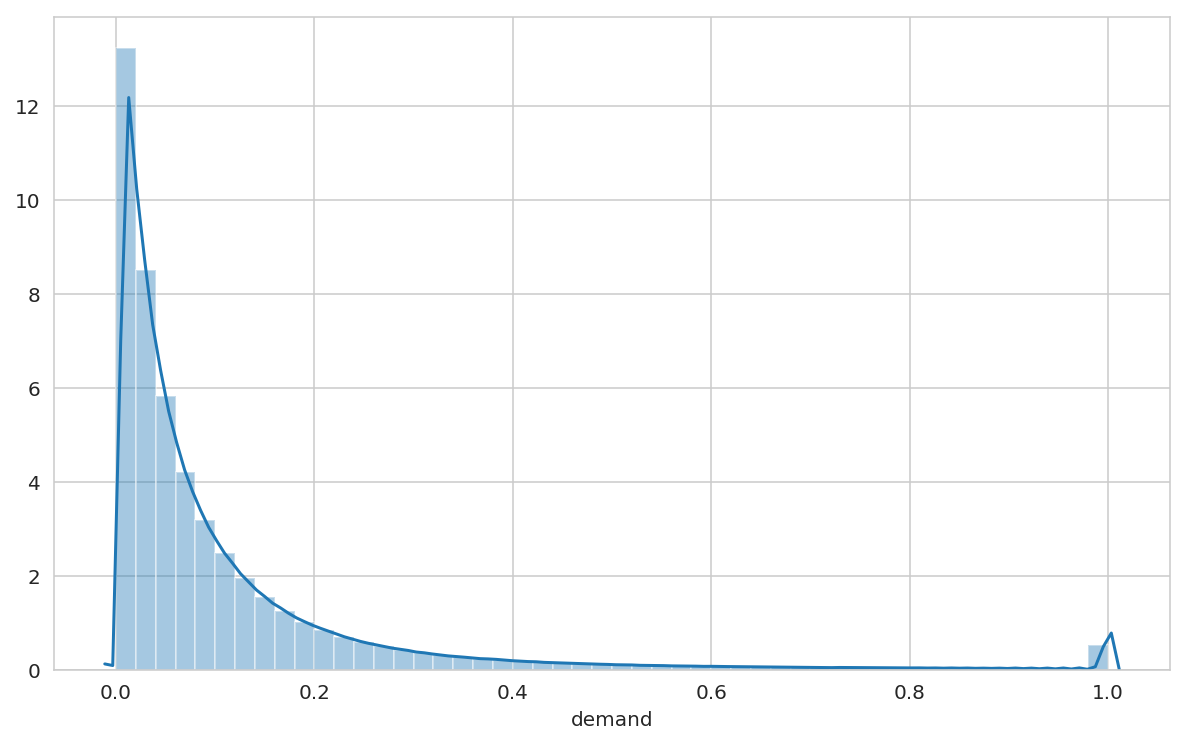

In [4]:
plt.figure(figsize=(10,6))
sns.distplot(df['demand'], label='demand')

#demand follows a lognormal distribution

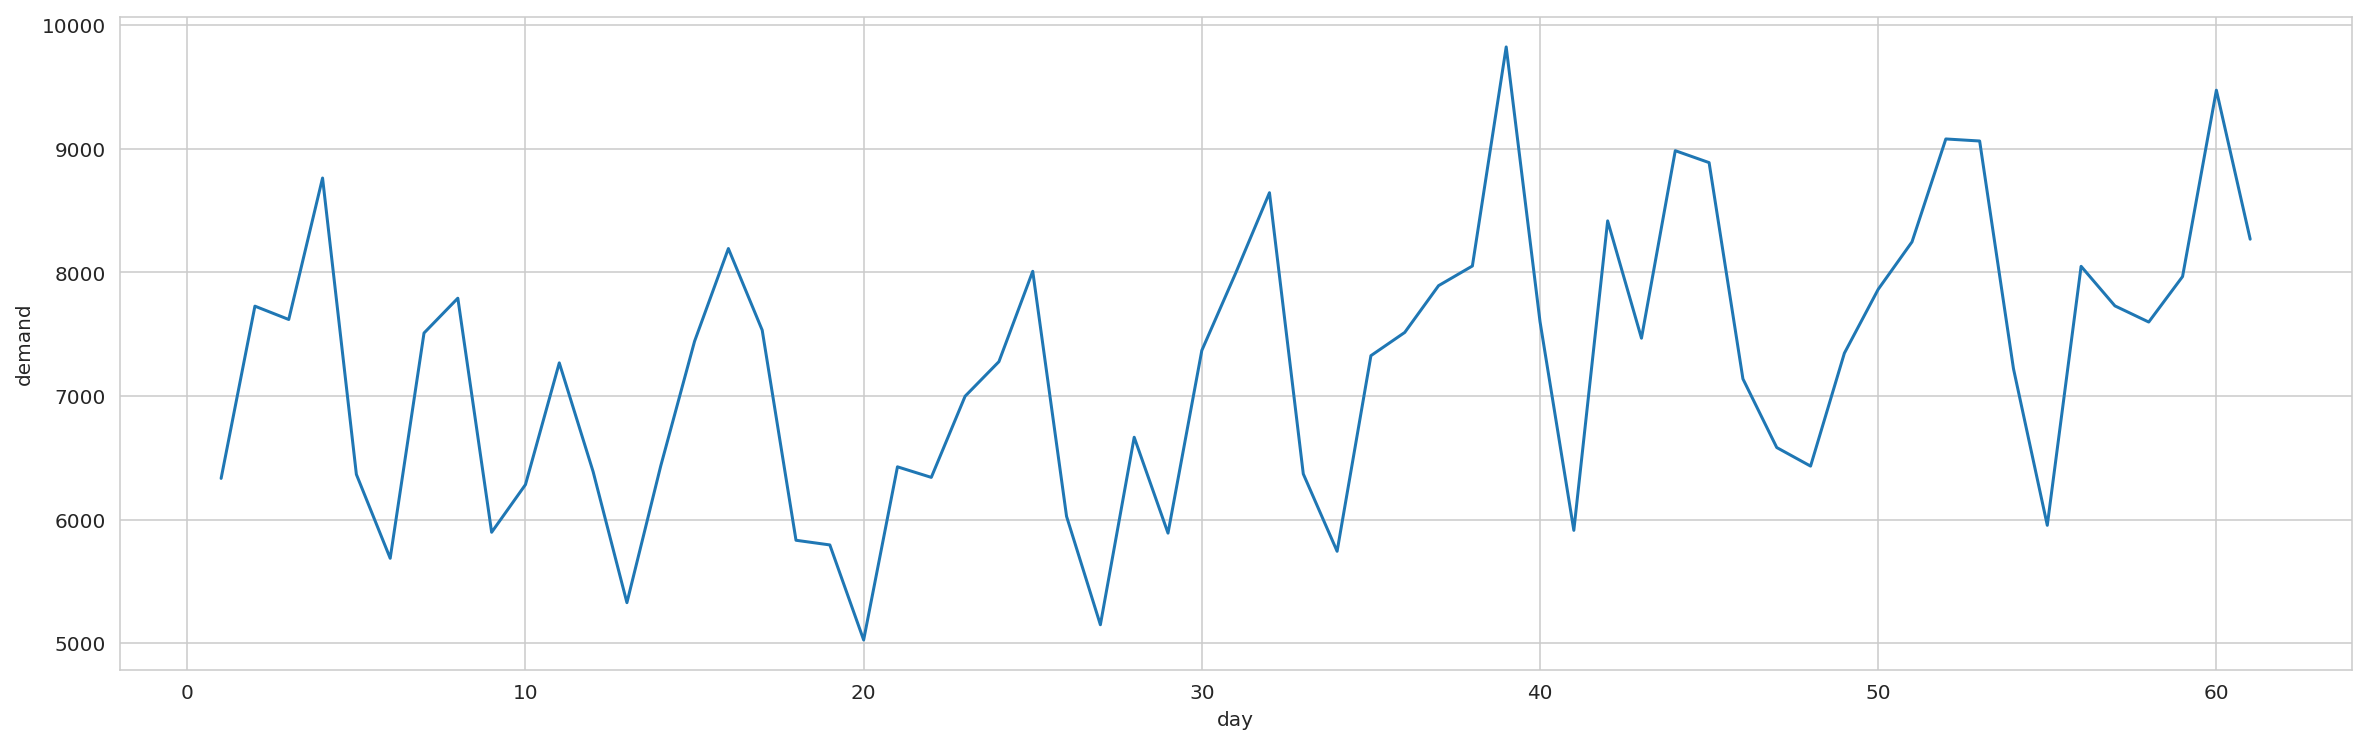

In [5]:
fig, ax = plt.subplots(figsize=(20,6))
dd_ts = df.groupby('day')['demand'].sum().reset_index()
sns.lineplot(x='day', y='demand', data=dd_ts, ax=ax)
plt.show()
#day trend shows demand growing with cyclical effects

#  Create a dummy datetime using 2019 1st Jan as startdate

In [6]:
from datetime import timedelta
df['day_time'] = df['day'].astype('str') +':'+ df['timestamp']
df['day_time2'] = df['day_time'].apply(lambda x: x.split(':'))
df['day_time3'] = df['day_time2'].apply(lambda x: timedelta(days=int(x[0]),hours=int(x[1]),minutes=int(x[2])))
df['dum_time'] = pd.Timestamp(2019,1,1).normalize() + df['day_time3']
df.drop(['day_time','day_time2','day_time3'],axis=1,inplace=True) # drop irrelevant columns
df.head()

geohash6  day timestamp    demand            dum_time
0   qp03wc   18      20:0  0.020072 2019-01-19 20:00:00
1   qp03pn   10     14:30  0.024721 2019-01-11 14:30:00
2   qp09sw    9      6:15  0.102821 2019-01-10 06:15:00
3   qp0991   32       5:0  0.088755 2019-02-02 05:00:00
4   qp090q   15       4:0  0.074468 2019-01-16 04:00:00

In [7]:
df['time'] = df['dum_time'].dt.time
df['hour'] = df['dum_time'].dt.hour
df['minute'] = df['dum_time'].dt.minute

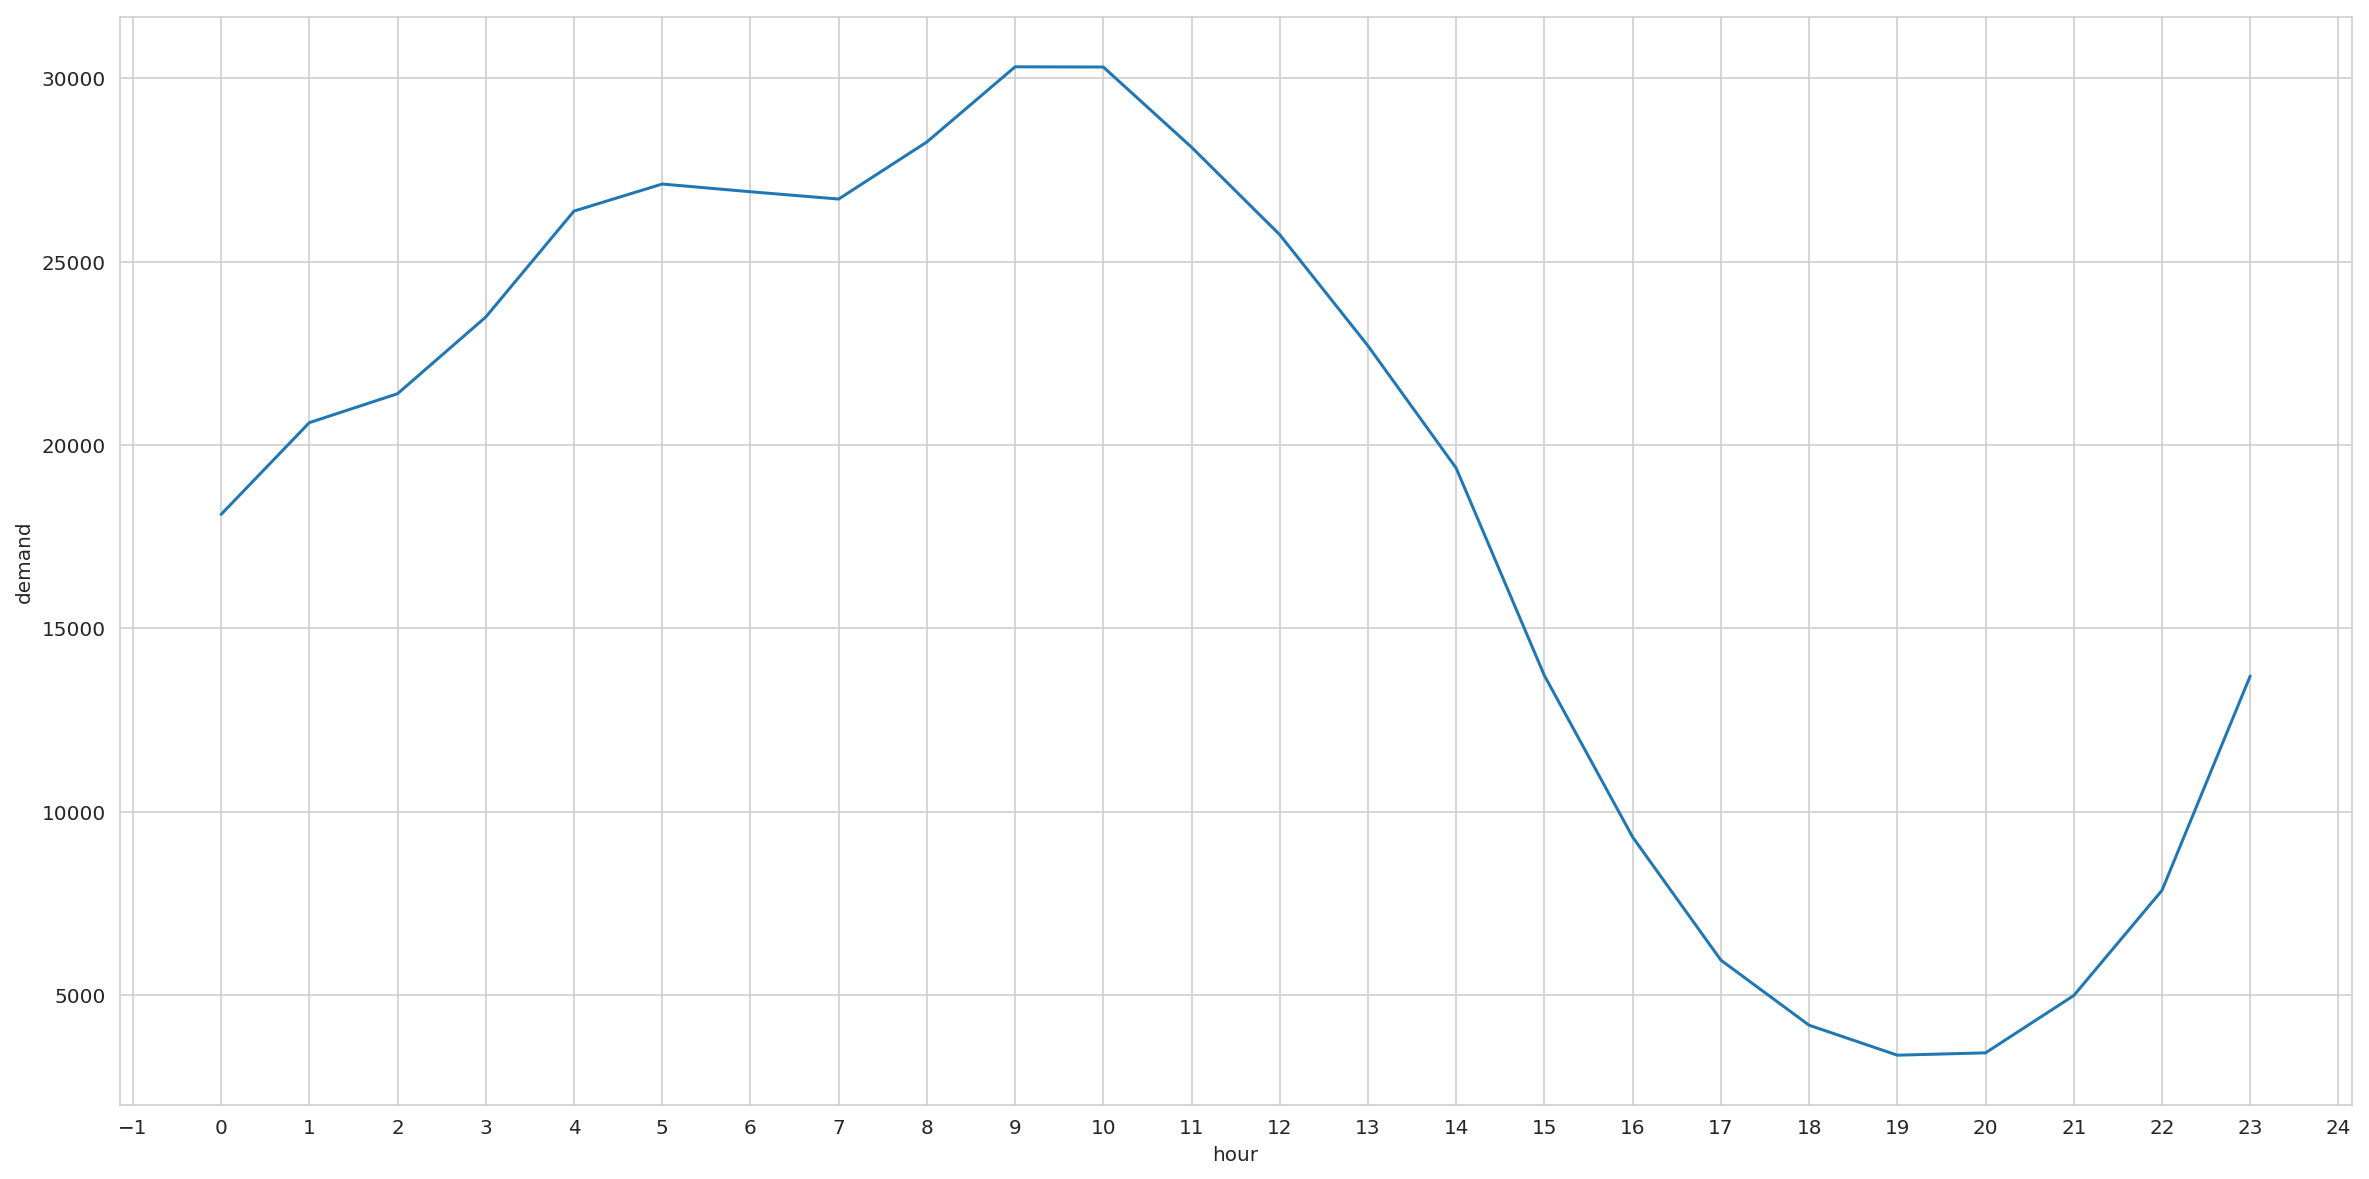

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
dd_ts = df.groupby('hour')['demand'].sum().reset_index()
sns.lineplot(x='hour', y='demand', data=dd_ts, ax=ax)
loc = plticker.MultipleLocator() # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()
#time trend shows peak in the morning and trough at 1900-2000hrs

Create day cycles of 7s

In [9]:
daycycle_dict1 = {}
for i in range(1,8):
    j = i
    while j <= 61:
        daycycle_dict1[j] = i
        j+=7
df['daycycle'] = df['day'].apply(lambda x: daycycle_dict1[x])

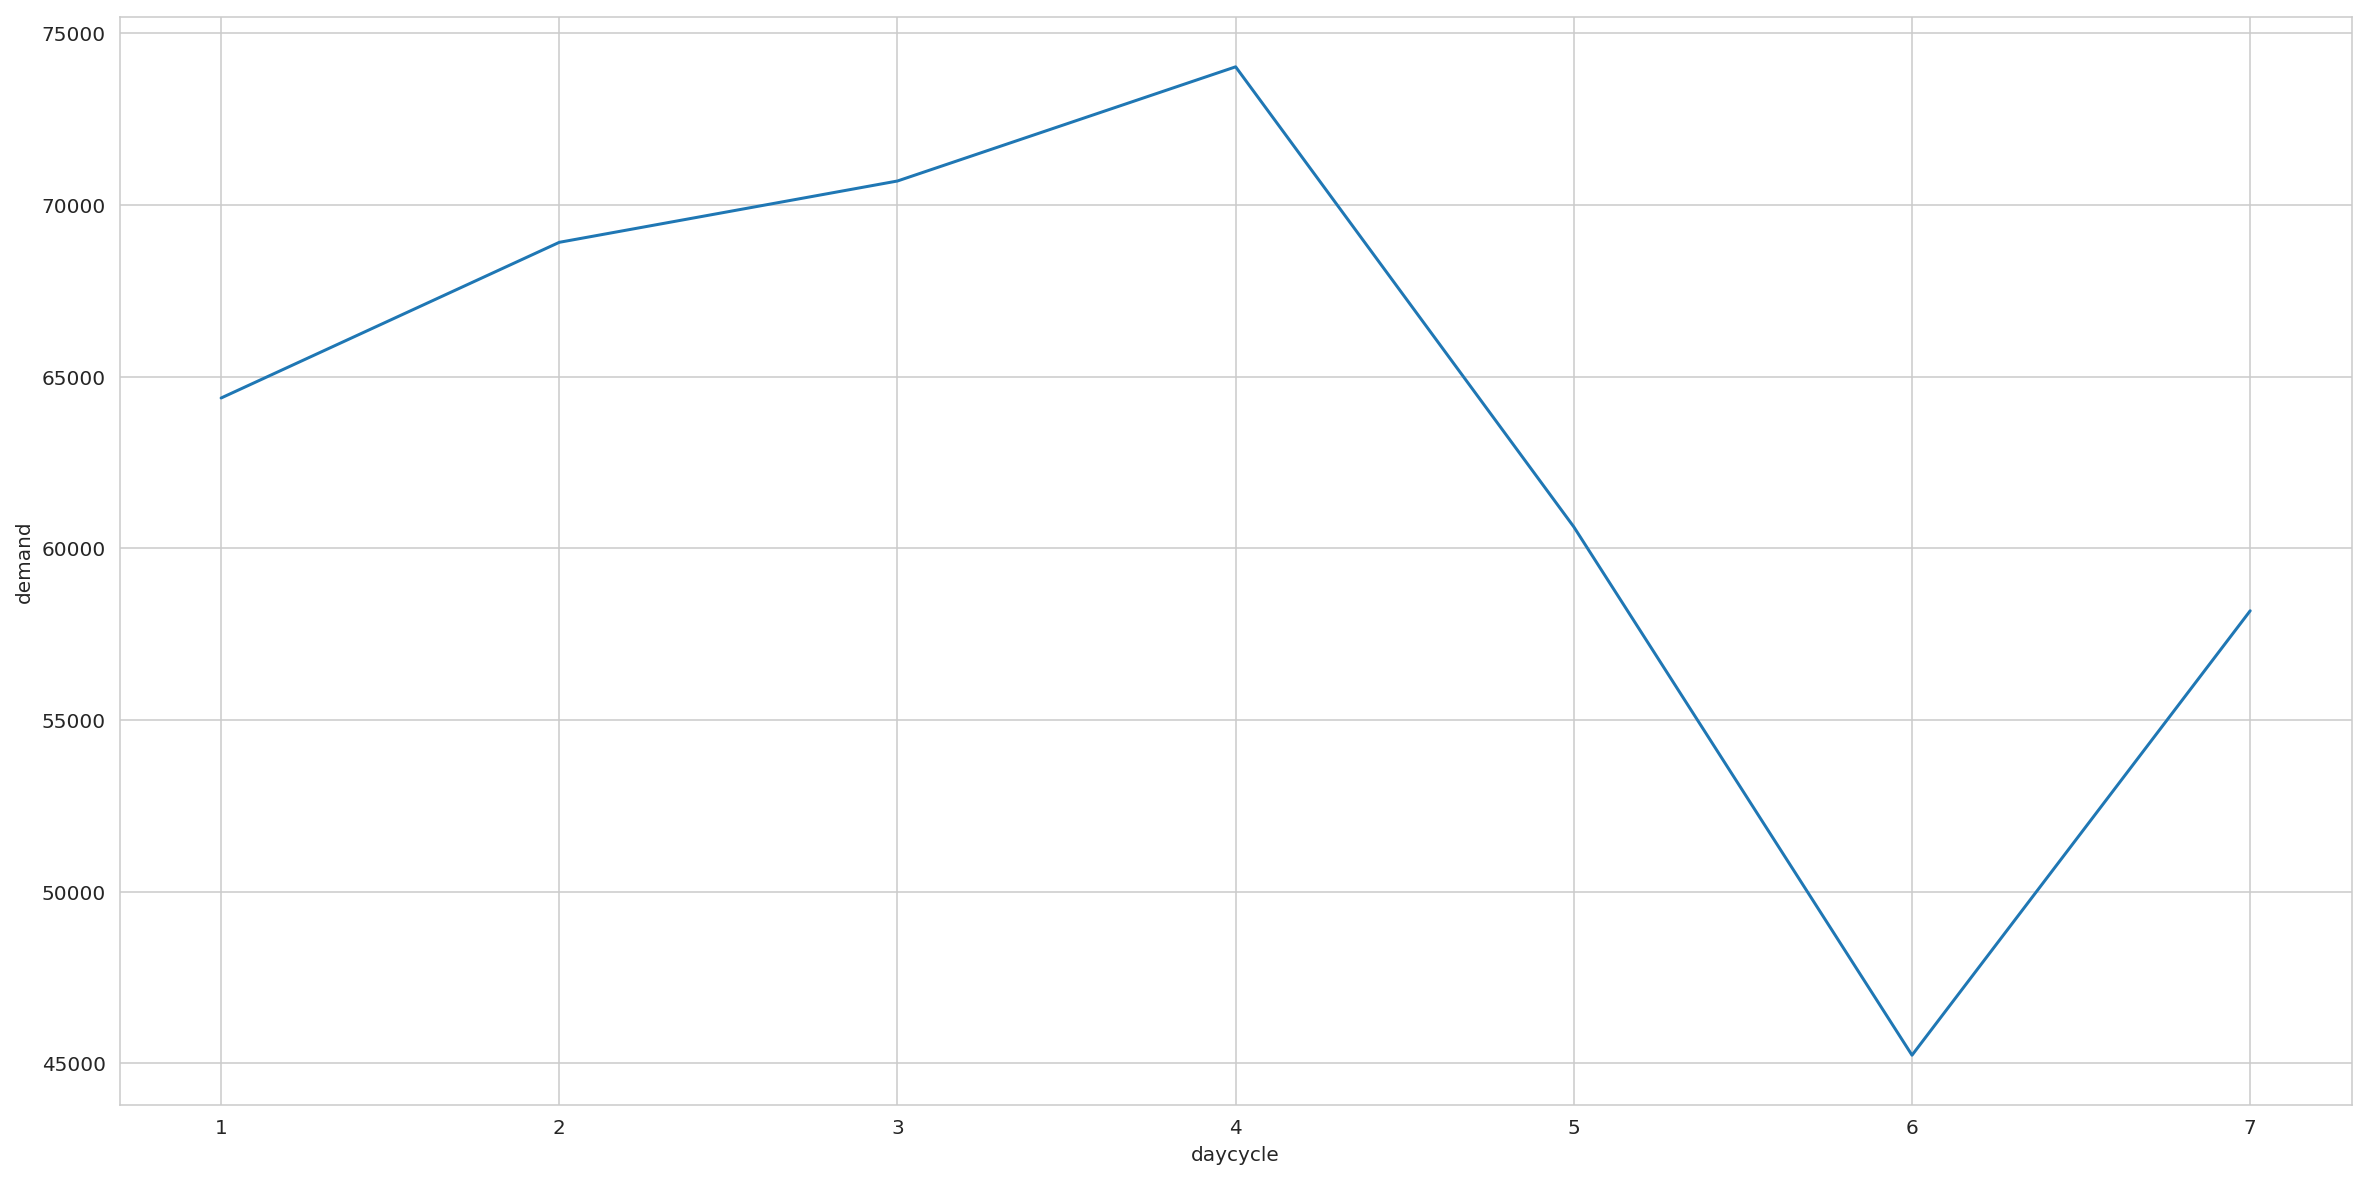

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
dd_ts = df.groupby('daycycle')['demand'].sum().reset_index()
sns.lineplot(x='daycycle', y='demand', data=dd_ts, ax=ax)
plt.show()
#Each day of the week has different demand. The 5th & 6th days could be the weekends due to the change in demand behaviour.

In [11]:
df['geohash6'].value_counts().sort_values().head()
#there are locations with 1 or little datapoints

qp09v9    1
qp08fs    1
qp092b    1
qp09tg    1
qp09mv    1
Name: geohash6, dtype: int64

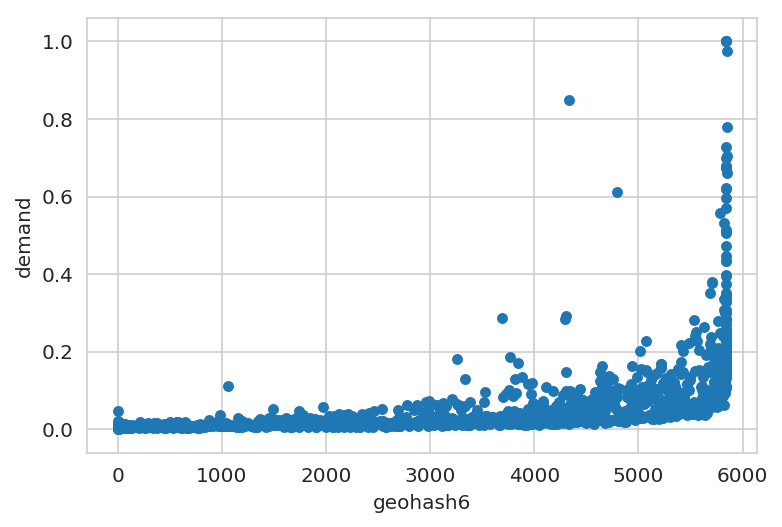

In [12]:
df.groupby('geohash6').agg(
    {
         'demand':"median",    # median demand for each location
         'geohash6': "count",  # no. of datapoints for each location
    }
).plot(x="geohash6", y="demand", kind="scatter")

Low demand areas indeed has less datapoints. <br>
Assume the missing datapoint is due to zero demand at location for the particular day time. <br>

## Get lat & long

In [13]:
df['latitude'] = df['geohash6'].apply(lambda x: geo.decode_exactly(x)[0])
df['longitude'] = df['geohash6'].apply(lambda x: geo.decode_exactly(x)[1])

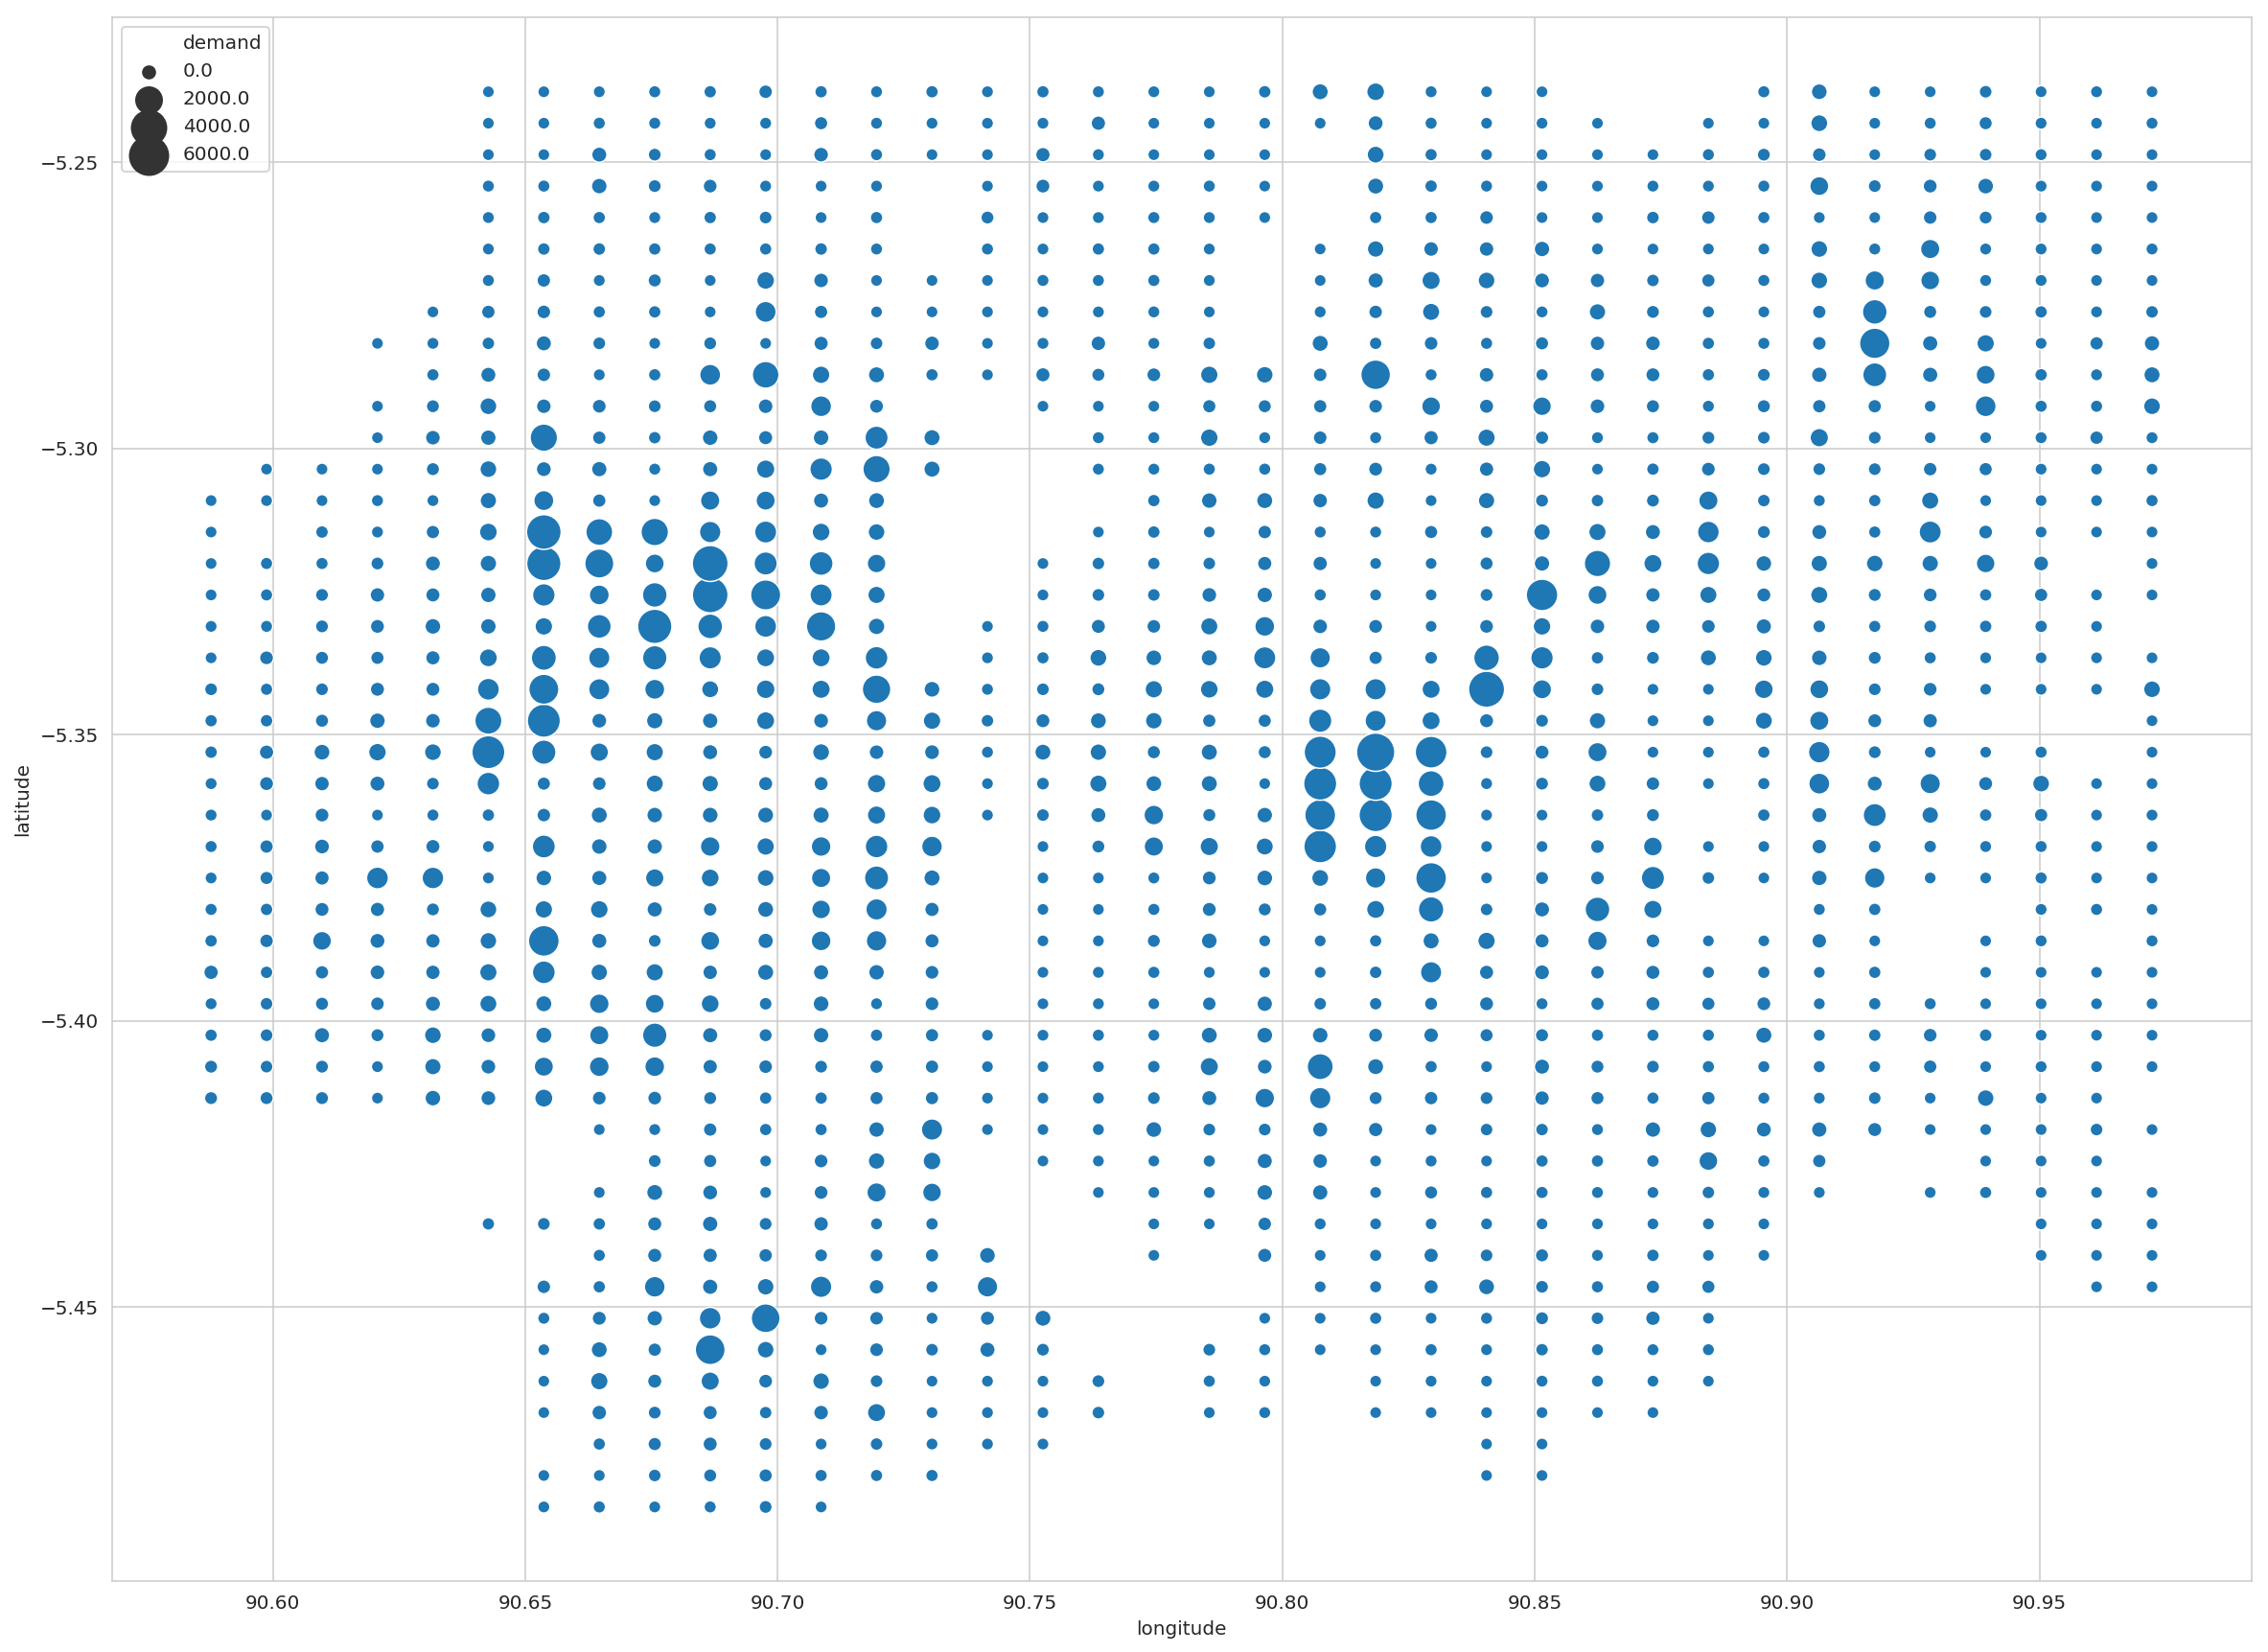

In [14]:
fig, ax = plt.subplots(figsize=(20,15))
dd_loc = df.groupby(['latitude','longitude'])['demand'].sum().reset_index()
sns.scatterplot(x='longitude', y='latitude', size='demand', sizes=(40, 400), data=dd_loc, ax=ax)
plt.show()

In [15]:
df2 = df.groupby(['geohash6','latitude','longitude'])['demand'].agg(['sum','std']).fillna(0).reset_index() #treat those with nan standard deviation as 0
df2.head()

geohash6  latitude  longitude        sum       std
0   qp02yc -5.484924  90.653687  13.241847  0.023054
1   qp02yf -5.479431  90.653687   1.369168  0.016277
2   qp02yu -5.468445  90.653687   0.044074  0.027530
3   qp02yv -5.462952  90.653687   0.587017  0.078685
4   qp02yy -5.457458  90.653687   2.049370  0.028808

# Find location clusters based on proximity and demand indicators

In [16]:
X = df2.drop('geohash6',axis=1)
Xs  = StandardScaler().fit_transform(X)
Xs  = pd.DataFrame(Xs , columns = X.columns.values)
Xs.head()

latitude  longitude       sum       std
0 -2.040620  -1.240007 -0.524178 -0.380860
1 -1.957103  -1.240007 -0.543664 -0.496064
2 -1.790067  -1.240007 -0.545839 -0.304755
3 -1.706550  -1.240007 -0.544948  0.564859
4 -1.623032  -1.240007 -0.542548 -0.283038

In [17]:
def opt_clusters(X, scaling=StandardScaler, k=11):
    #choosing clusters with elbow within cluster sum square errors and silhouette score
    inertia = []
    silh = []
    #standardizing required
    Xs = StandardScaler().fit_transform(X)
    Xs = pd.DataFrame(Xs, columns = X.columns.values)
    for i in range(1,k):
        model = KMeans(n_clusters=i, random_state=0).fit(Xs)
        predicted = model.labels_
        inertia.append(model.inertia_)#low inertia = low cluster sum square error. Low inertia -> Clusters are more compact.
        if i>1:
            silh.append(silhouette_score(Xs, predicted, metric='euclidean')) #High silhouette score = clusters are well separated. The score is based on how much closer data points are to their own clusters (intra-dist) than to the nearest neighbor cluster (inter-dist): (cohesion + separation).  
    plt.plot(np.arange(1, k, step=1), inertia)
    plt.title('Innertia vs clusters')
    plt.xlabel('No. of clusters')
    plt.ylabel('Within Clusters Sum-sq (WCSS)')
    plt.show()
    plt.scatter(np.arange(2, k, step=1), silh)
    plt.title('Sihouette vs clusters')
    plt.xlabel('No. of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

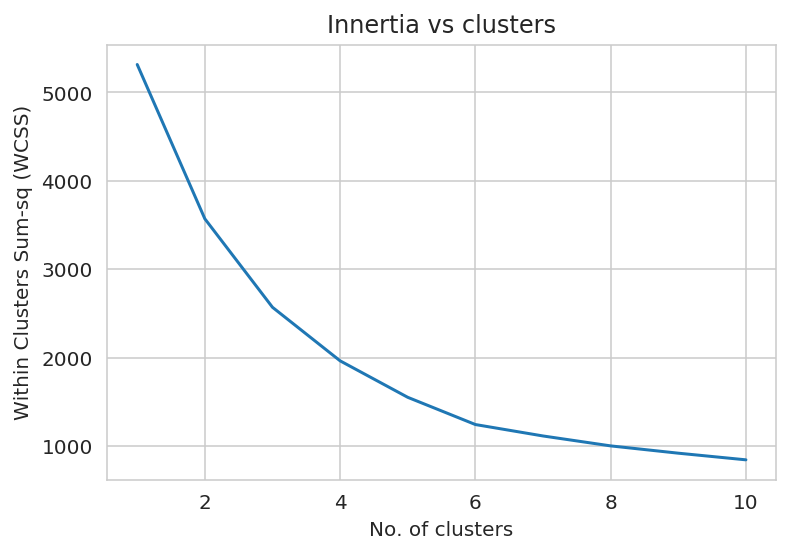

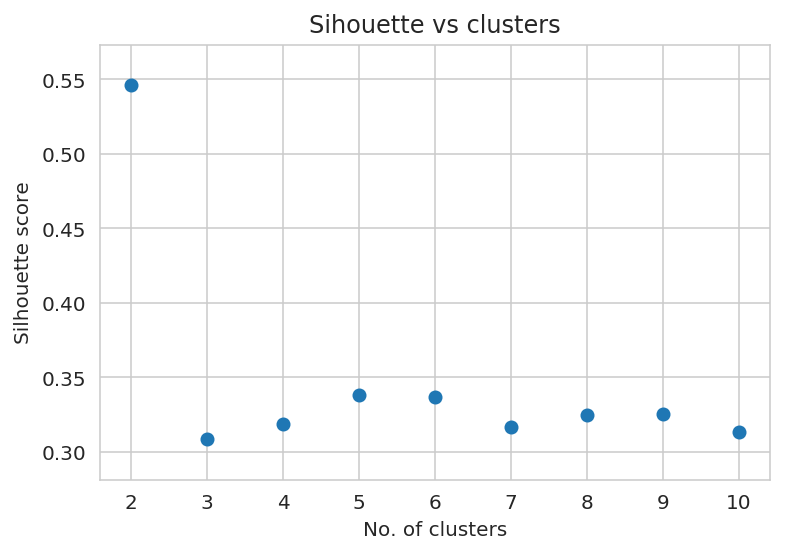

In [18]:
opt_clusters(Xs, scaling=StandardScaler, k=11)

In [19]:
#getting prediction and centroids
#select 6 clusters based on silhouette and WCSS
kmeans = KMeans(n_clusters=6, random_state=0).fit(Xs)
predicted = kmeans.labels_
centroids = kmeans.cluster_centers_
Xs['predicted'] = predicted #or X['predicted'] = predicted

In [20]:
df2['cluster'] = Xs['predicted']

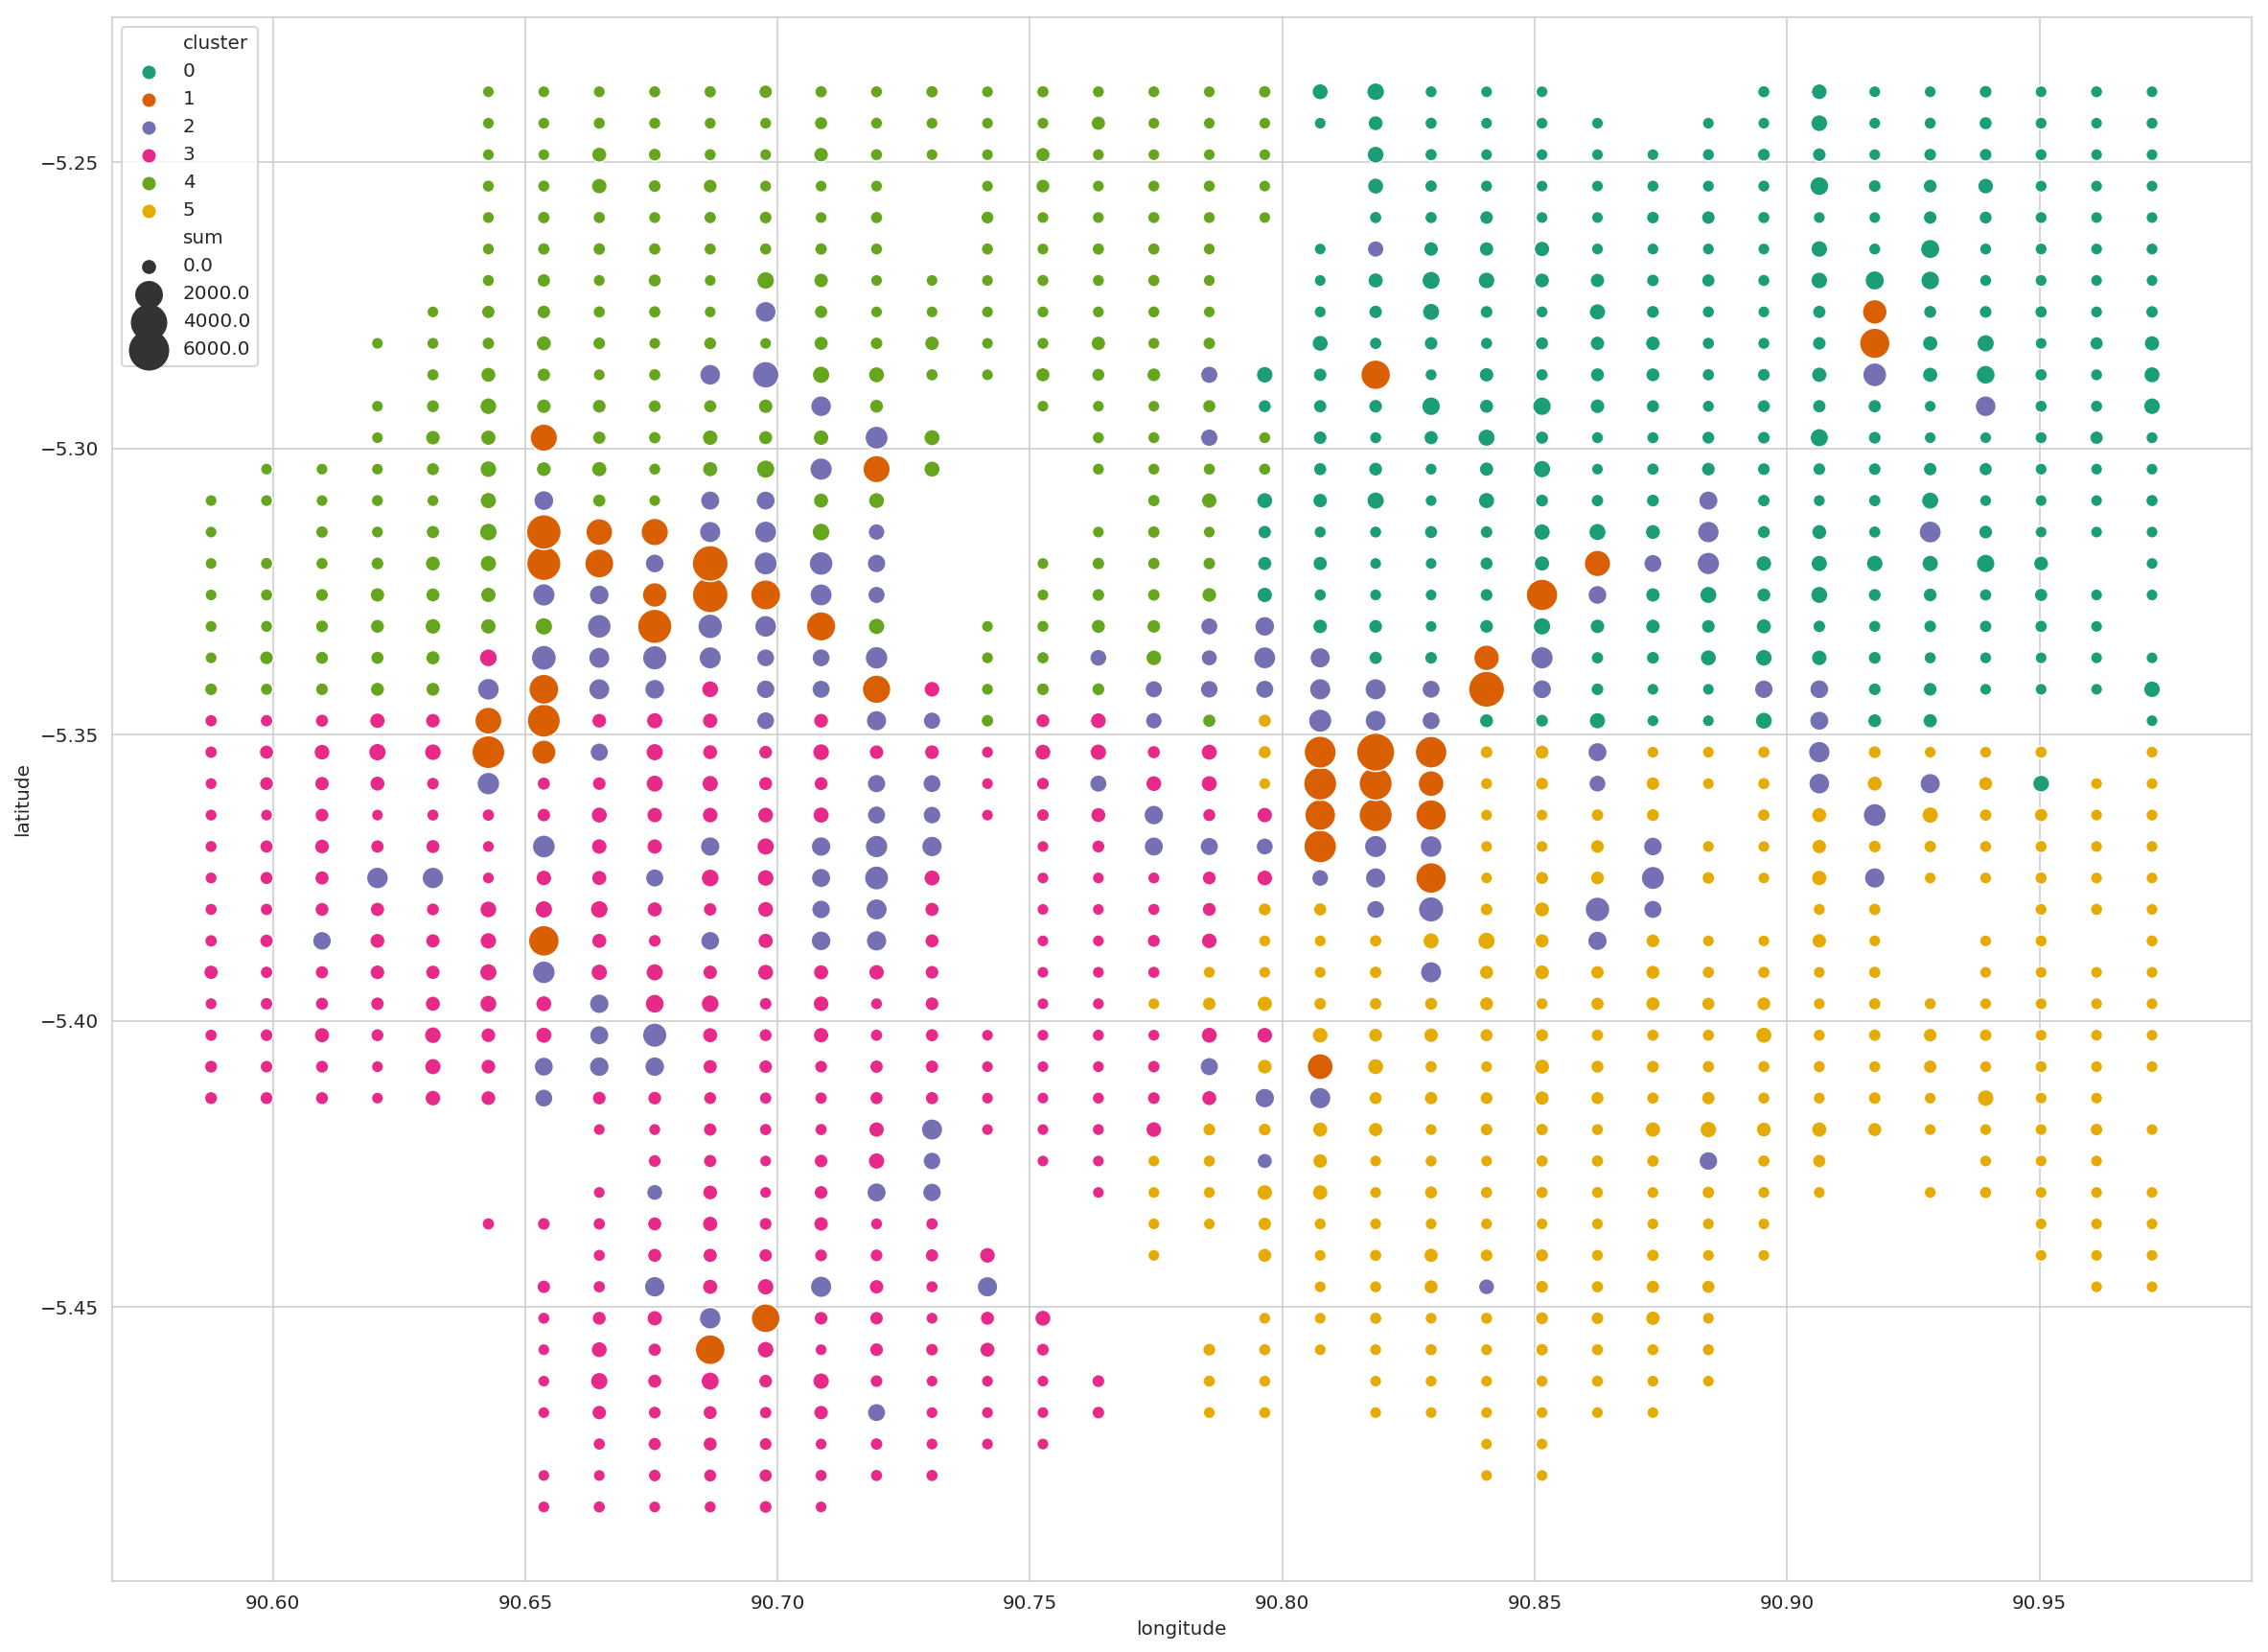

In [21]:
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', size='sum', hue='cluster', palette=sns.color_palette("Dark2", 6), sizes=(40, 400), data=df2, ax=ax)
plt.show()

# Looks like the k-mean models has clustered 3 main type of locations
1. 1st tier size clusters which probably are the centres of activities
2. 2nd tier size clusters which probably are the busier areas nearby centres
3. Areas with lower activities, seperated into NE NW SE SW

In [22]:
#create a dictionary for these locations
cluster_dict = df2[['geohash6','cluster']].set_index('geohash6')['cluster'].to_dict()
df['cluster'] = df['geohash6'].apply(lambda x: cluster_dict[x])
loc_dict = {0:'clust0', 1:'clust1', 2:'clust2', 3:'clust3', 4:'clust4', 5:'clust5'}
df['cluster'] = df['cluster'].apply(lambda x: loc_dict[x])

In [23]:
df.head()

geohash6  day timestamp   ...    latitude  longitude cluster
0   qp03wc   18      20:0   ...   -5.353088  90.653687  clust1
1   qp03pn   10     14:30   ...   -5.413513  90.664673  clust3
2   qp09sw    9      6:15   ...   -5.325623  90.906372  clust0
3   qp0991   32       5:0   ...   -5.353088  90.752563  clust3
4   qp090q   15       4:0   ...   -5.413513  90.719604  clust3

[5 rows x 12 columns]

# Tried VAR Time series forecast. Results were not encouraging. Use LSTM to predict cluster demand for t+1,t+2,...,t+5

Preprocessing to create cluster time series dataframe

In [24]:
#Grouping and pivoting each cluster's demand
lstm_df = df.groupby(['dum_time','cluster','daycycle','hour','minute'])['demand'].sum().reset_index()
lstm_df.set_index('dum_time', inplace=True)

lstm_df2 = pd.pivot_table(lstm_df, values = 'demand', index=['dum_time','daycycle','hour','minute'], columns = 'cluster').reset_index()
lstm_df2.set_index('dum_time',inplace=True)

In [25]:
lstm_df2.head()

cluster              daycycle  hour    ...       clust4    clust5
dum_time                               ...                       
2019-01-02 00:00:00         1     0    ...     2.345024  1.125130
2019-01-02 00:15:00         1     0    ...     2.705397  1.576896
2019-01-02 00:30:00         1     0    ...     2.816383  1.738240
2019-01-02 00:45:00         1     0    ...     2.720643  2.002632
2019-01-02 01:00:00         1     1    ...     3.021357  2.676783

[5 rows x 9 columns]

In [26]:
#Standardizing demand min max for better processing of neural nets
series = lstm_df2.drop(['daycycle','hour','minute'],axis=1)
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(series.values)
series_ss = pd.DataFrame(scaled)

series_ss.columns = list(series.columns)
series_ss.set_index(series.index, inplace=True)
series_ss.head()

clust0    clust1    ...       clust4    clust5
dum_time                                   ...                       
2019-01-02 00:00:00  0.080617  0.230397    ...     0.136428  0.066699
2019-01-02 00:15:00  0.086336  0.242307    ...     0.158537  0.093575
2019-01-02 00:30:00  0.098205  0.257680    ...     0.165346  0.103174
2019-01-02 00:45:00  0.125642  0.264805    ...     0.159472  0.118903
2019-01-02 01:00:00  0.160323  0.290232    ...     0.177921  0.159009

[5 rows x 6 columns]

In [27]:
#get dataset for each time series forecast t+1, t+2, t+3, t+4, t+5
tseries_dict = {}
for step in range(1,6):
    y = series_ss.copy()
    ts_prior = series_ss.shift(step)
    y.columns = [j + str(step) for j in list(series_ss.columns)]
    dummies = pd.get_dummies(lstm_df2[['daycycle','hour','minute']], columns = ['daycycle','hour','minute'],drop_first=True)
    tseries_dict[step] = pd.concat([ts_prior,dummies,y],axis=1).dropna()

In [28]:
###### function to split into train and test sets
def train_test_prep(data):
    values = data.values
    n_train_time = round(0.9*len(data))
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]
    ##test = values[n_train_time:n_test_time, :]
    # split into input and outputs
    train_X, train_y = train[:, :-6], train[:, -6:]
    test_X, test_y = test[:, :-6], test[:, -6:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    return train_X, train_y, test_X, test_y
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

In [29]:
# print(round(0.9*len(tseries_dict[1])))
# tseries_dict[1].iloc[5256,:]
# date where training set starts is 2019-02-25 22:00:00

In [30]:
#split into train/test X&y datasets for each step forecast
Xts_train = {}
Xts_test = {}
yts_train = {}
yts_test = {}
for step in range(1,6):
    Xts_train[step], yts_train[step], Xts_test[step], yts_test[step] = train_test_prep(tseries_dict[step])

tseries_dict[step].shape

(5835, 44)

In [31]:
#define training model
def model_train(train_X,train_y,test_X,test_y):
    model = Sequential()
    model.reset_states()
    model.add(LSTM(input_shape=(train_X.shape[1], train_X.shape[2]), output_dim=50, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(6))
    model.compile(loss='mean_squared_error', optimizer='adam')    
    history = model.fit(train_X, train_y, epochs=20, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)        
    return model

In [32]:
#train and save models forecasting t+1,t+2,...,t+5
models_dict = {}

for step in range(1,6):
    model = model_train(Xts_train[step], yts_train[step], Xts_test[step], yts_test[step])
    model.save('timestep_'+str(i)+'.h5')
    models_dict[step] = model

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 38), return_sequences=True, units=50)`
  """


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 38), return_sequences=True, units=50)`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 38), return_sequences=True, units=50)`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 38), return_sequences=True, units=50)`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(1, 38), return_sequences=True, units=50)`
  """


In [33]:
#get error and forecast plot on test set
def model_predict(model,test_X,test_y):
    # make a prediction
    yhat = model.predict(test_X)
    # invert scaling for forecast
    yhat = yhat.reshape((len(test_y), 6))
    inv_yhat = scaler.inverse_transform(yhat)

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 6))
    inv_y = scaler.inverse_transform(test_y)

    rmse_ls = []
    for i in range(0,6):
        rmse_ls.append(mean_squared_error(pd.DataFrame(inv_y)[i], pd.DataFrame(inv_yhat)[i]))

    mean_val = pd.DataFrame(inv_yhat).mean()
    error_df = pd.concat([pd.DataFrame(rmse_ls, columns=['rmse']),mean_val],axis=1)
    error_df['%_error'] = error_df['rmse']/error_df[0]*100
    error_df.columns = ['rmse','mean_val','%_error']
    print(error_df)
    
#     for i in range(0,6):
#         print(series.columns[i])
#         plt.plot(inv_y[:,i], marker='.', label="actual")
#         plt.plot(inv_yhat[:,i], 'r', label="prediction")
#         plt.legend(fontsize=10)
#         plt.show()
    
    fig, ax = plt.subplots(2, 3, figsize=(20,10))
    ax[0, 0].plot(inv_y[:,0], marker='.', label="actual")
    ax[0, 1].plot(inv_y[:,1], marker='.', label="actual")
    ax[0, 2].plot(inv_y[:,2], marker='.', label="actual")
    ax[1, 0].plot(inv_y[:,3], marker='.', label="actual")
    ax[1, 1].plot(inv_y[:,4], marker='.', label="actual")
    ax[1, 2].plot(inv_y[:,5], marker='.', label="actual")
    ax[0, 0].plot(inv_yhat[:,0], marker='.', label="prediction")
    ax[0, 1].plot(inv_yhat[:,1], marker='.', label="prediction")
    ax[0, 2].plot(inv_yhat[:,2], marker='.', label="prediction")
    ax[1, 0].plot(inv_yhat[:,3], marker='.', label="prediction")
    ax[1, 1].plot(inv_yhat[:,4], marker='.', label="prediction")
    ax[1, 2].plot(inv_yhat[:,5], marker='.', label="prediction")
    ax[0, 0].title.set_text('Cluster0')
    ax[0, 1].title.set_text('Cluster1')
    ax[0, 2].title.set_text('Cluster2')
    ax[1, 0].title.set_text('Cluster3')
    ax[1, 1].title.set_text('Cluster4')
    ax[1, 2].title.set_text('Cluster5')
    ax[0, 0].legend(fontsize=10,loc='upper right')
    plt.show()
    return inv_yhat

Forecast time ahead  1
       rmse   mean_val    %_error
0  2.277341  10.070227  22.614591
1  4.779653  22.045834  21.680529
2  7.852037  26.684225  29.425763
3  2.525867  12.601833  20.043645
4  0.427612   5.775712   7.403632
5  0.676129   5.071659  13.331524


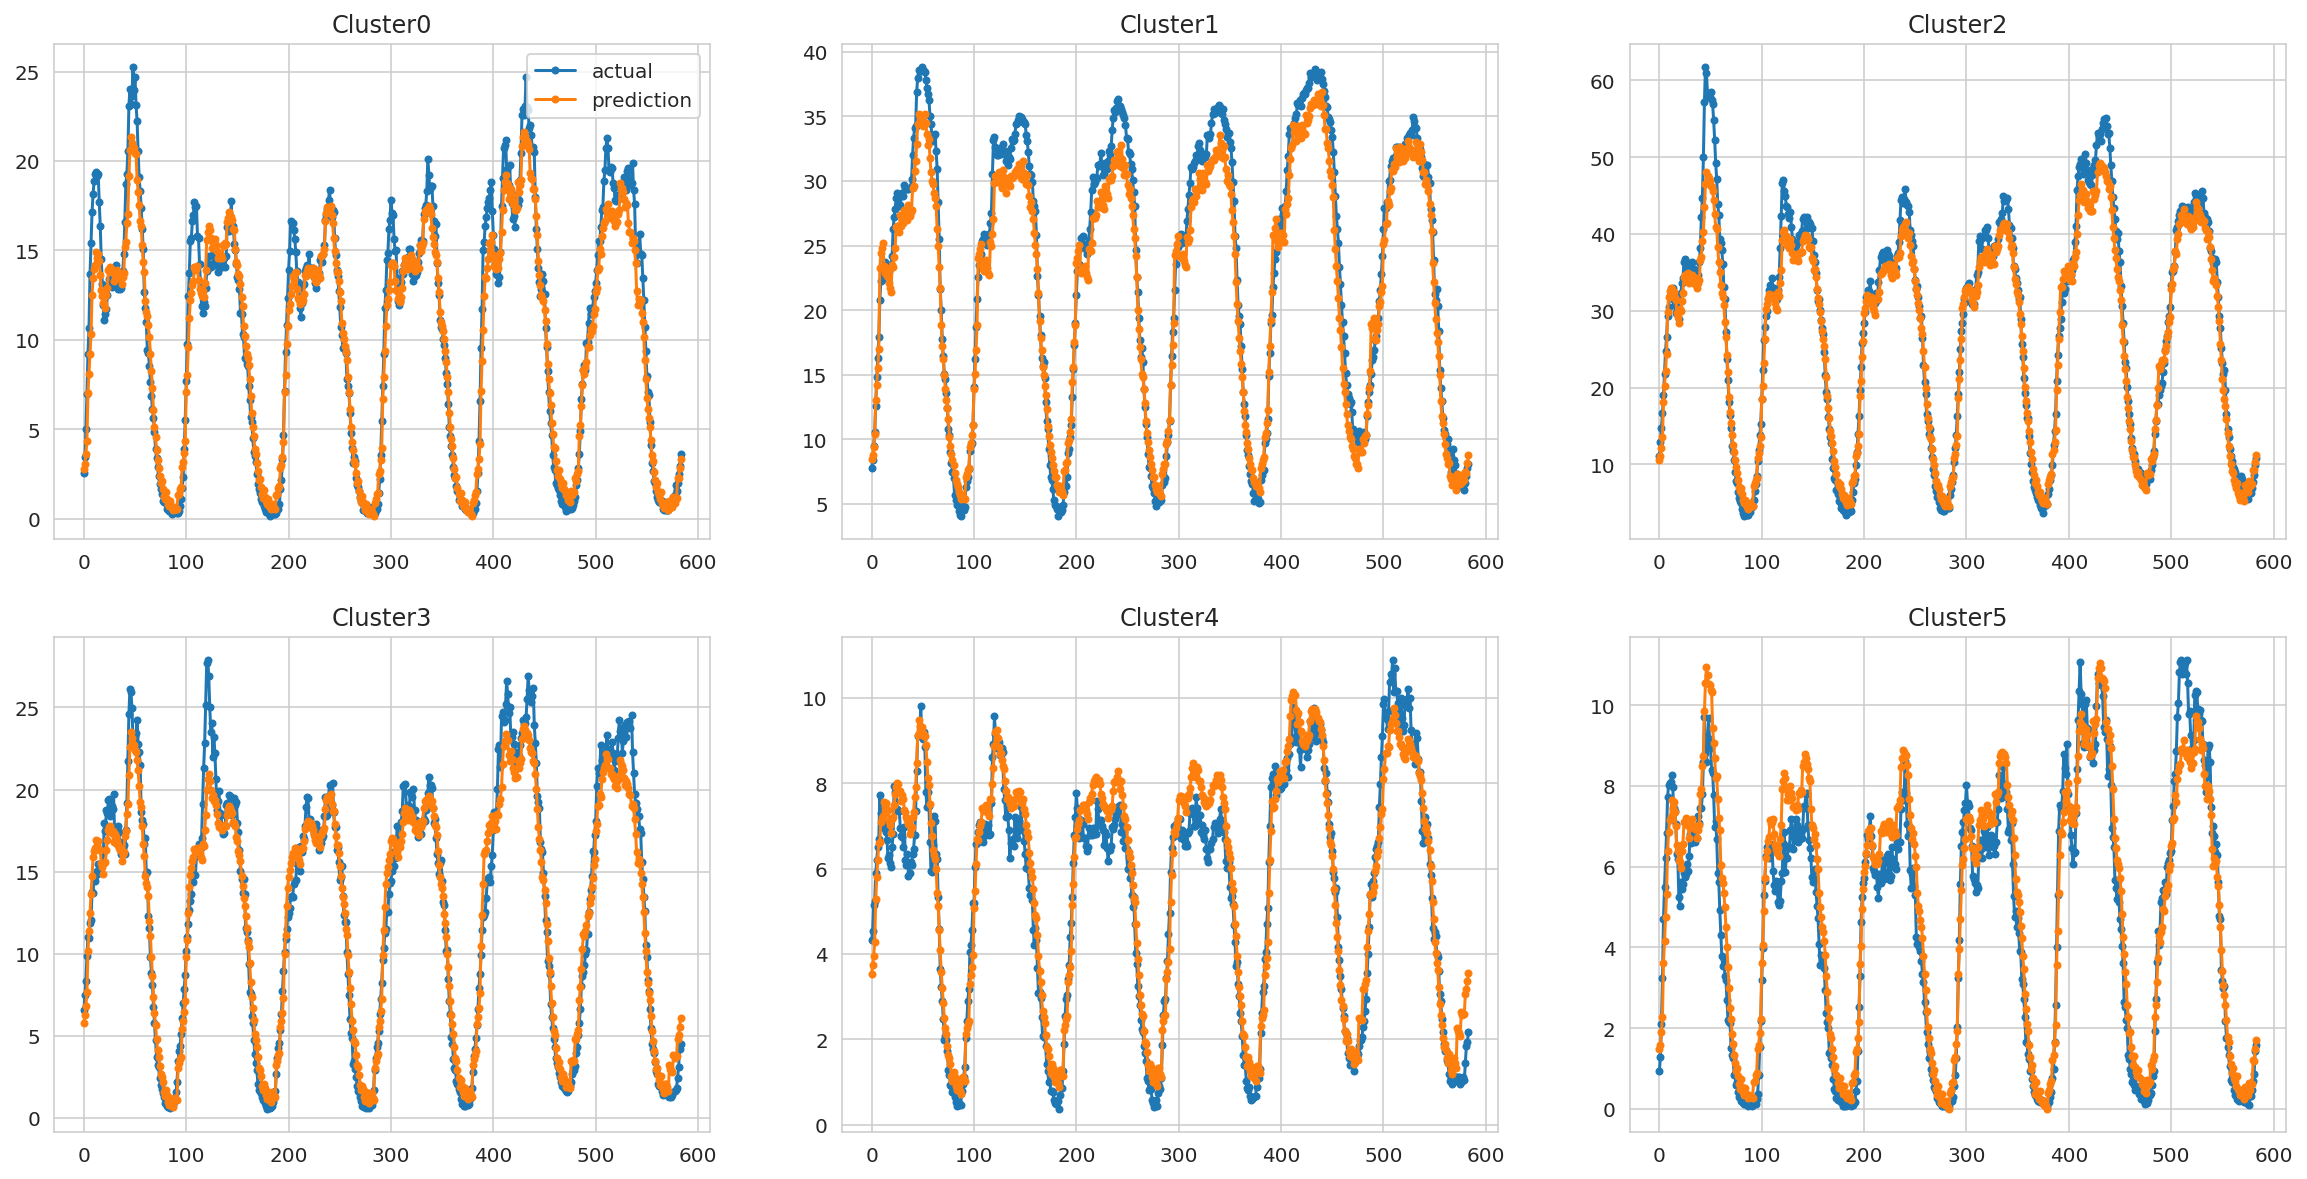

Forecast time ahead  2
       rmse   mean_val    %_error
0  2.904945   9.973243  29.127388
1  4.616008  21.983753  20.997363
2  8.504240  26.596828  31.974638
3  2.943322  12.418260  23.701563
4  0.467559   5.687660   8.220590
5  0.769635   5.016906  15.340828


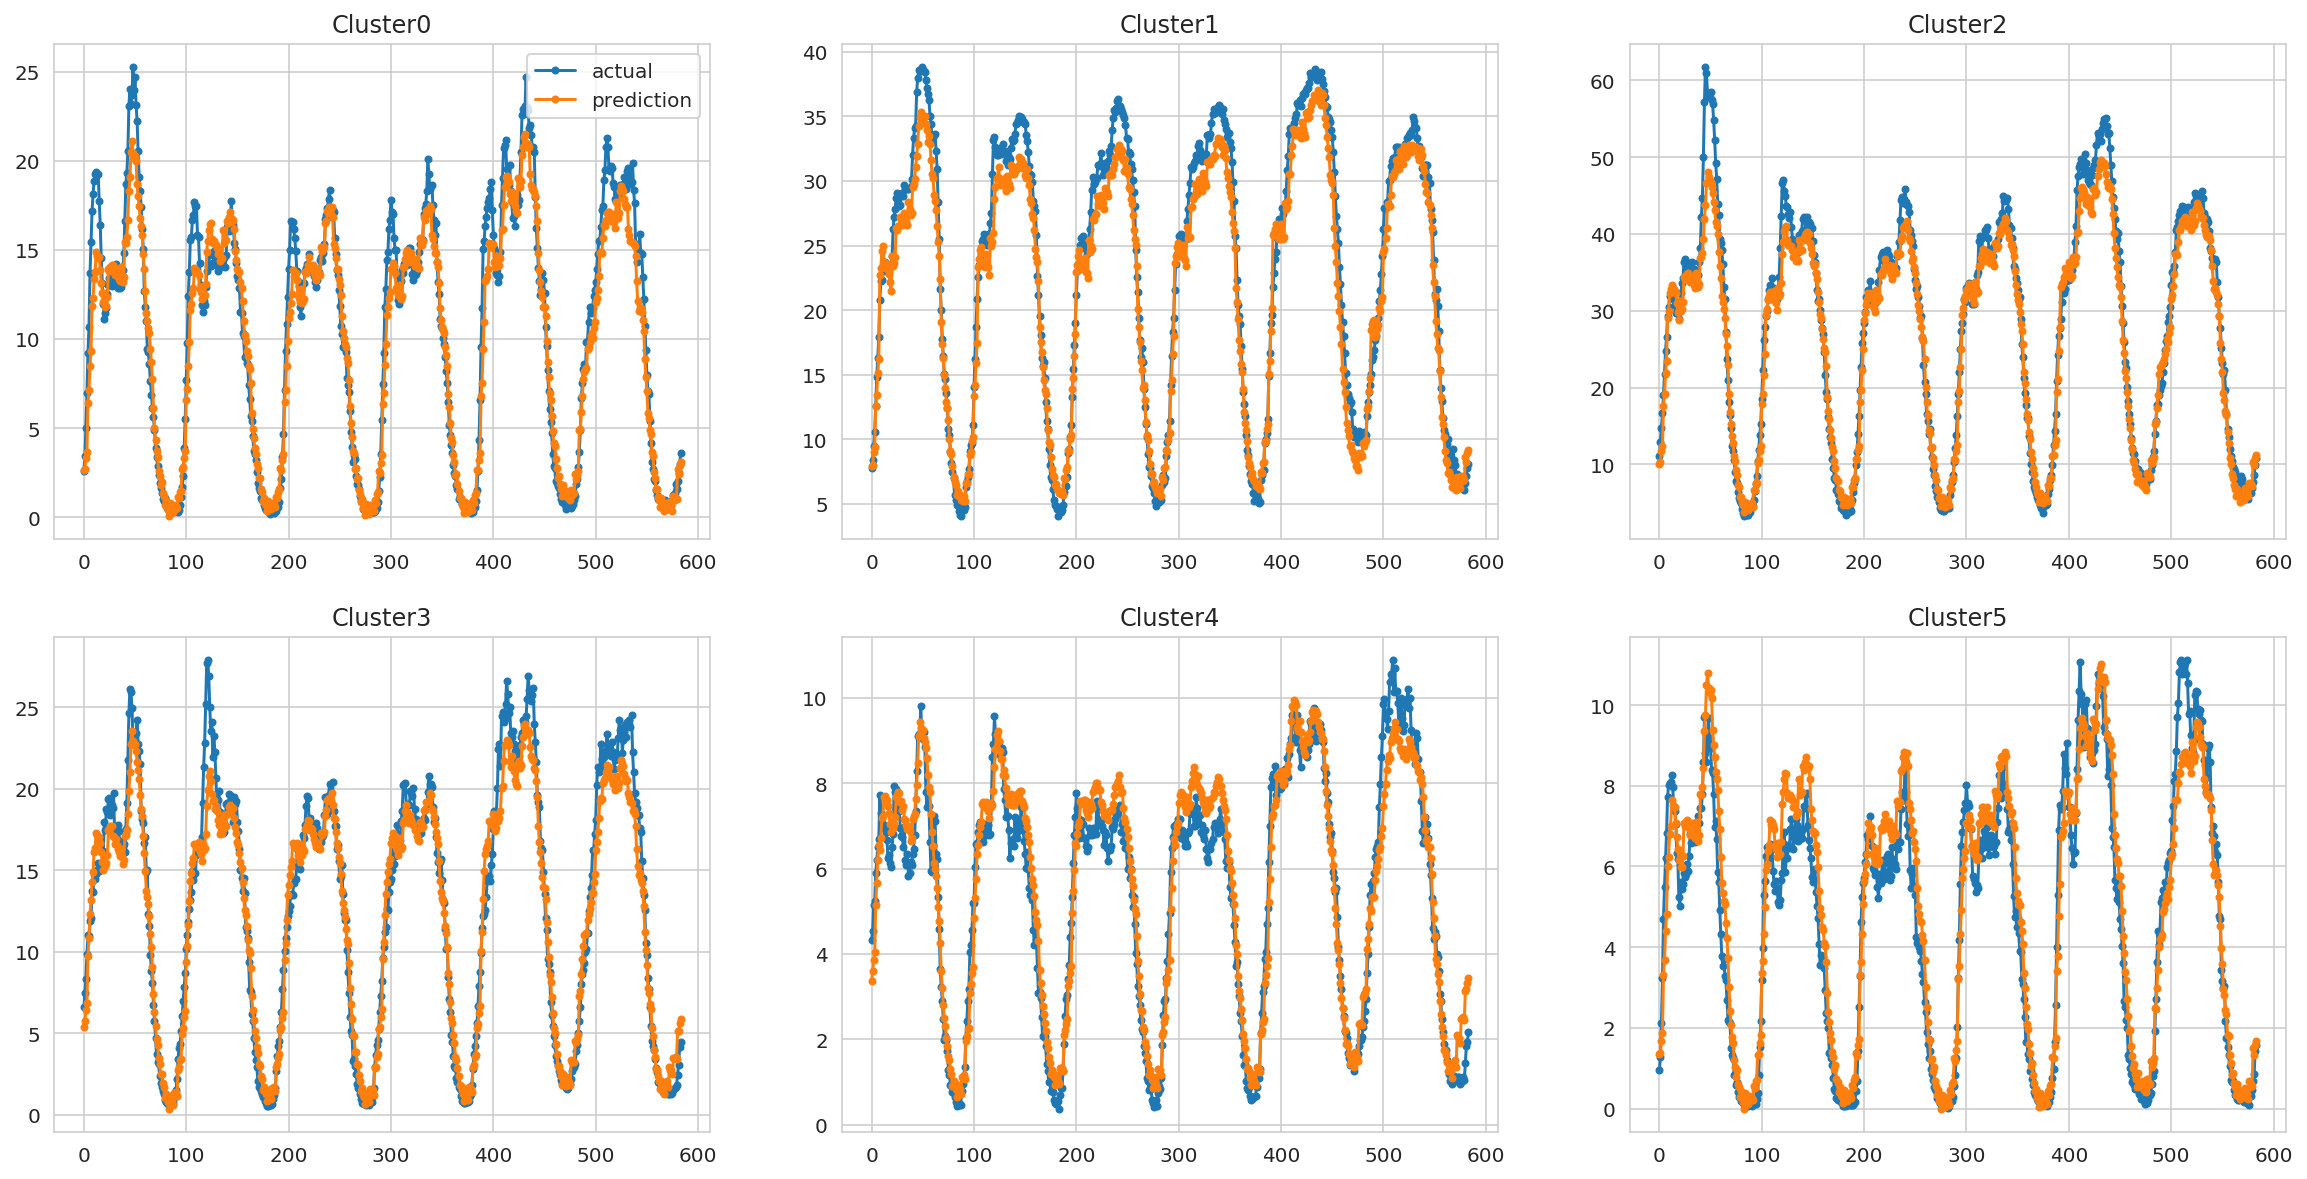

Forecast time ahead  3
        rmse   mean_val    %_error
0   3.064596  10.096335  30.353545
1   4.730810  22.110481  21.396231
2  10.118275  26.666145  37.944275
3   3.222938  12.513275  25.756150
4   0.603308   5.780279  10.437347
5   0.857686   5.052764  16.974582


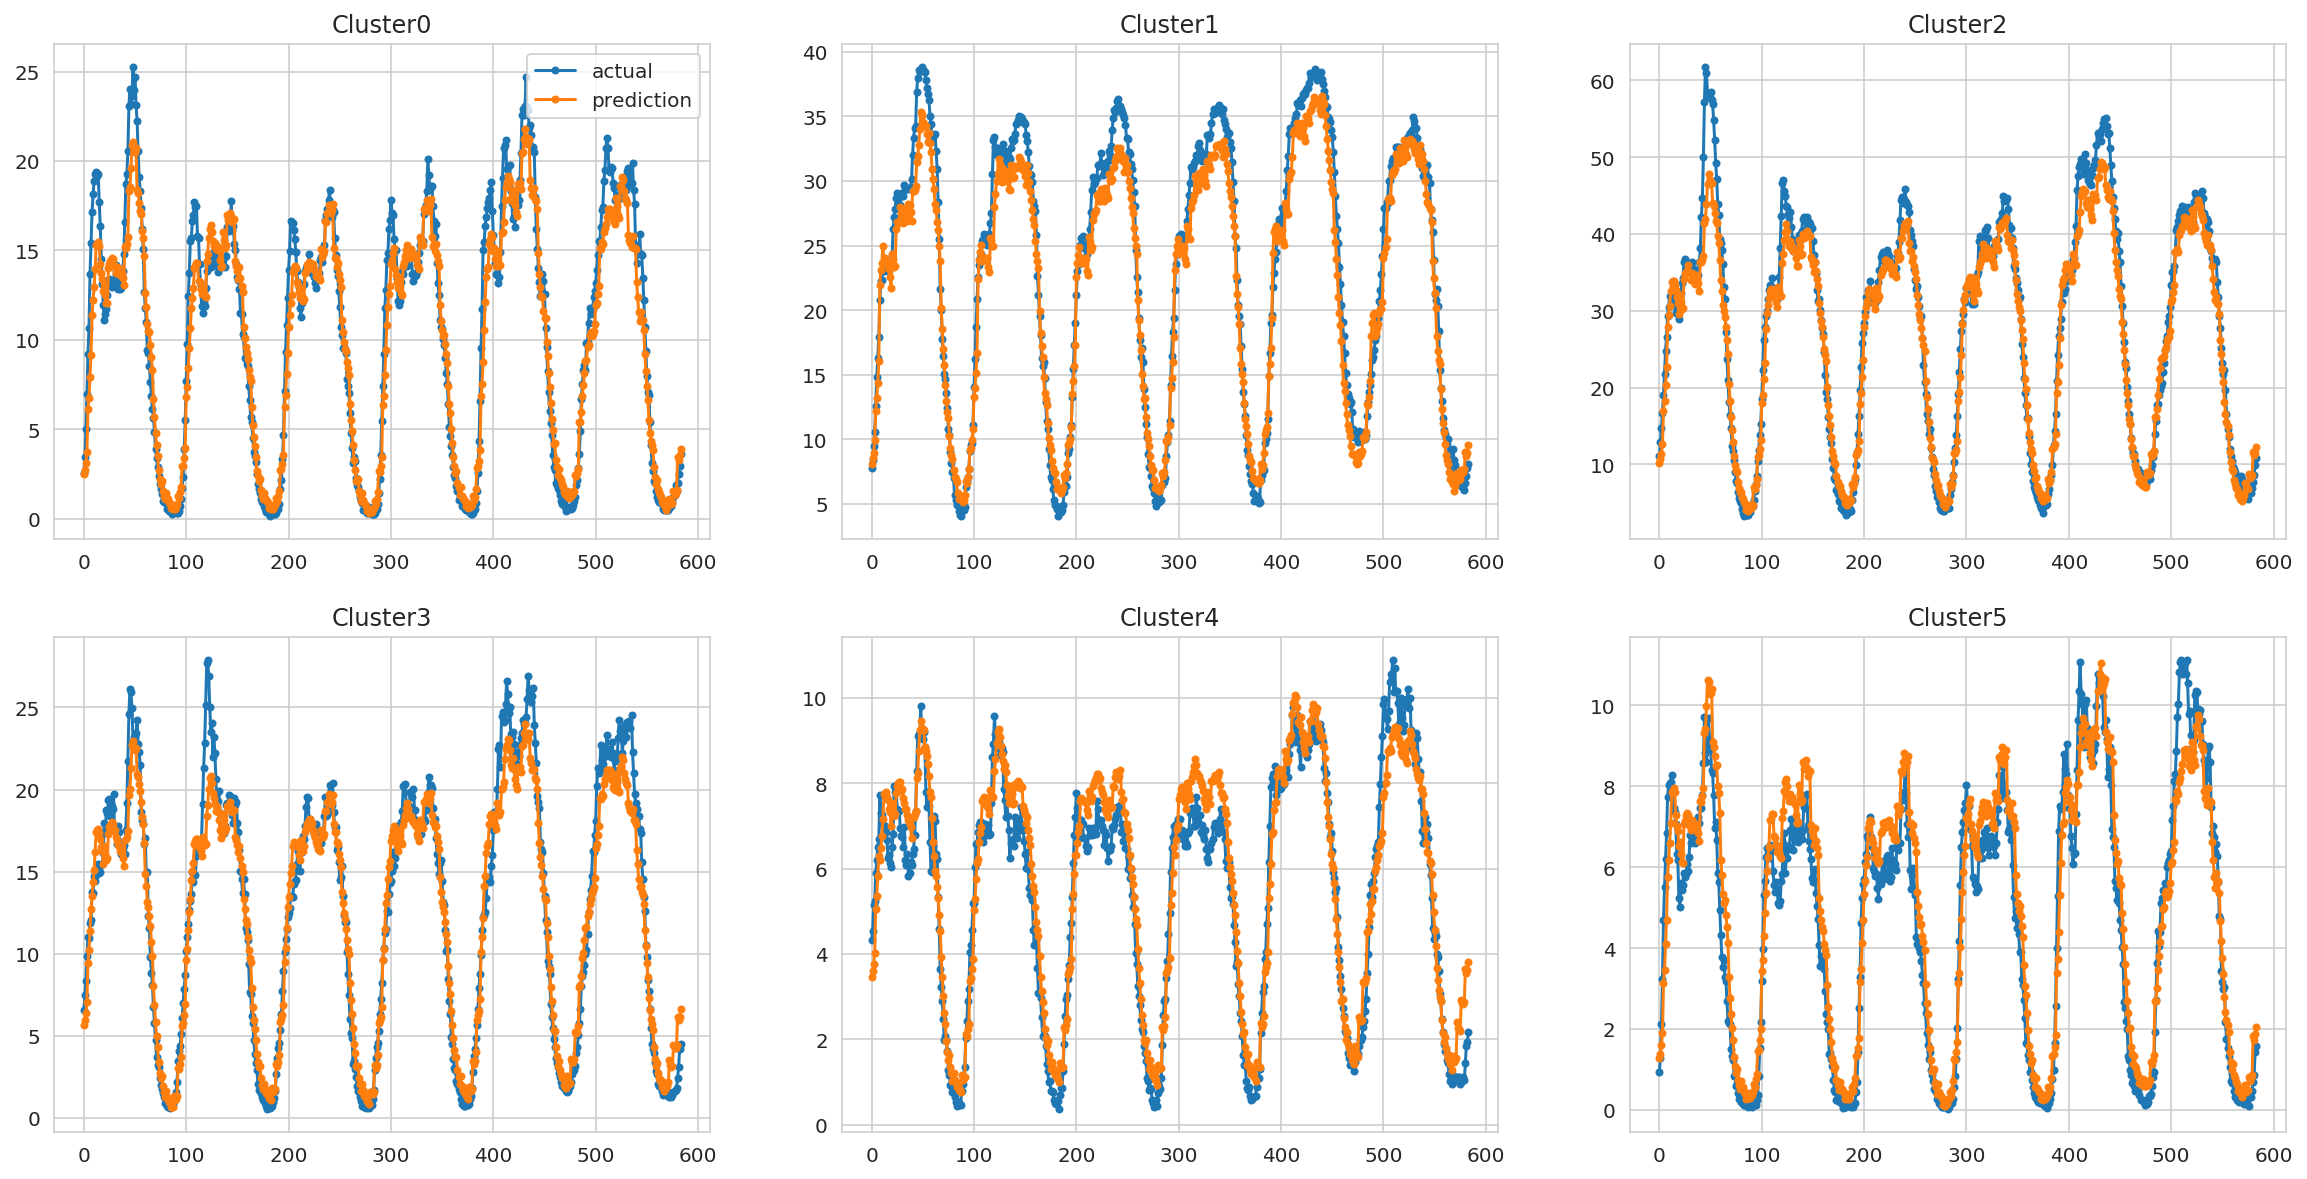

Forecast time ahead  4
        rmse   mean_val    %_error
0   3.912478  10.108341  38.705445
1   5.553935  21.872526  25.392290
2  10.986262  26.592535  41.313329
3   3.317634  12.495788  26.550017
4   0.706431   5.726065  12.337118
5   1.076324   5.040217  21.354710


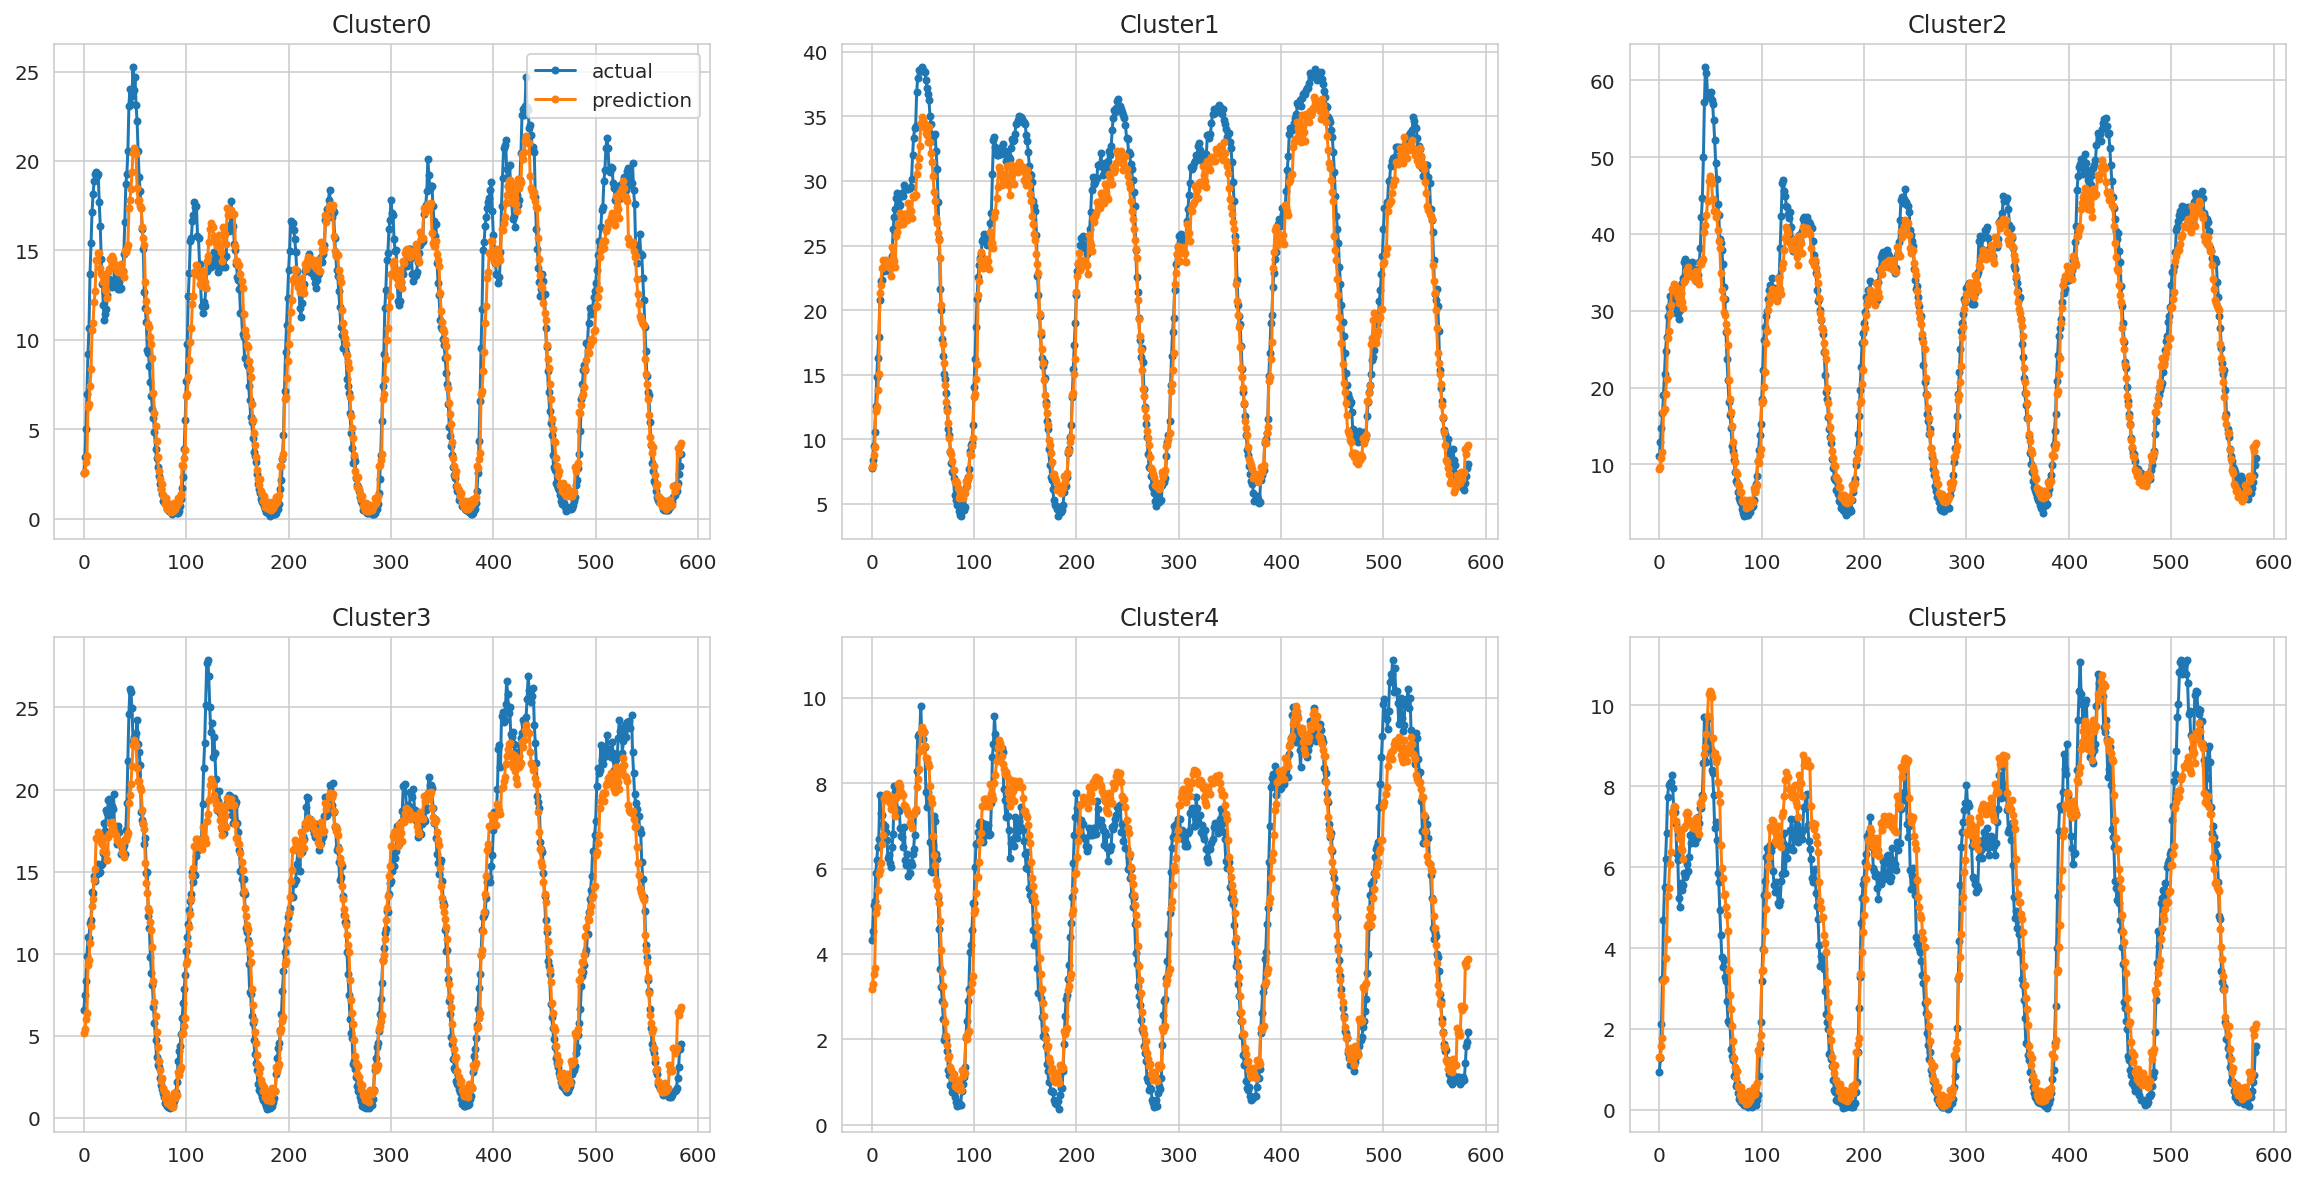

Forecast time ahead  5
        rmse   mean_val    %_error
0   4.374436  10.075460  43.416733
1   5.421226  21.939735  24.709624
2  12.208225  26.683357  45.752206
3   3.871653  12.439677  31.123422
4   0.744644   5.711849  13.036821
5   1.080334   4.977697  21.703486


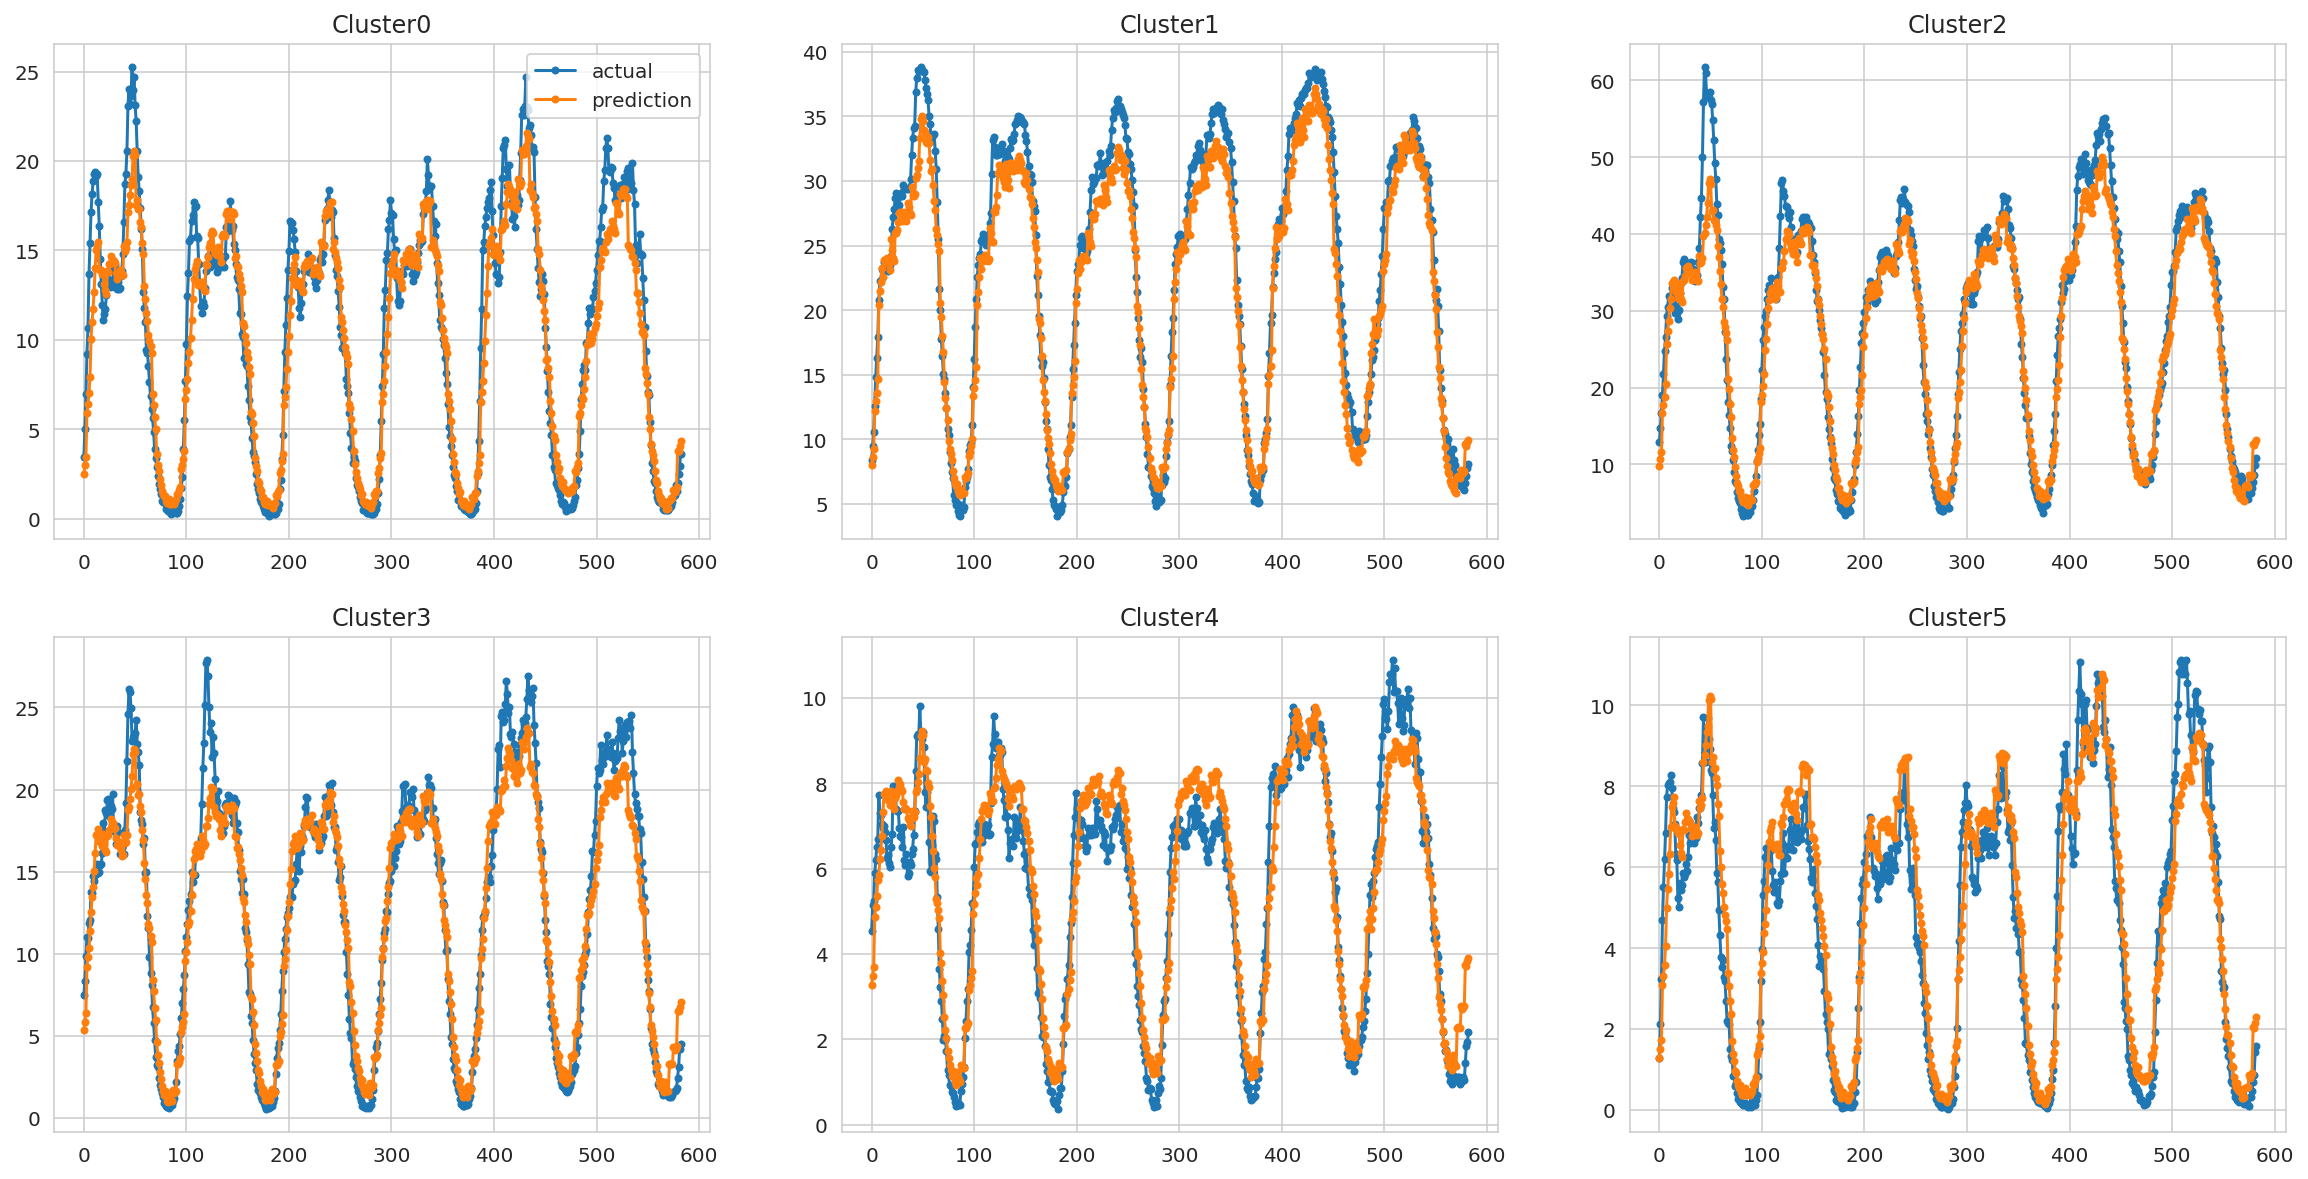

In [34]:
#save predicted cluster demand for each cluster for t+1,..t+5 into a data dictionary
y_pred = {}
for step in range(1,6):
    print('Forecast time ahead ', step)
    y_pred[step] = model_predict(models_dict[step],Xts_test[step], yts_test[step])

#error increase as timestep ahead to predict increases

# Training Cross Sector Analysis
This analysis is to tease out the relationship of geolocation demand proportion to its overall cluster demand. <br>
The relationship is teased out at the level of geolocation's daycycle, hour & 15minute intervals.  

In [35]:
#standardize lat and long for analysis later
from sklearn.preprocessing import MinMaxScaler
lat_long = MinMaxScaler(feature_range=(0, 1), copy=True).fit_transform(df[['latitude','longitude']])
lat_long = pd.DataFrame(lat_long)
lat_long.columns = ['latitude','longitude']

df['latitude'] = lat_long['latitude']
df['longitude'] = lat_long['longitude']

In [36]:
#get proportion of demand for each geolocation, relative to the cluster and time
sector_dd = df.groupby(['cluster','dum_time'])['demand'].sum().reset_index()
df_sect_dd = df.merge(sector_dd, left_on = ['cluster','dum_time'], right_on = ['cluster','dum_time'],how = 'inner',suffixes=['','_sect'])
df_sect_dd['prop_dd'] = df_sect_dd['demand']/df_sect_dd['demand_sect']
df_sect_dd['prop_dd'] = df_sect_dd['prop_dd'].fillna(0)
df_sect_dd.head()

geohash6  day timestamp    ...     cluster demand_sect   prop_dd
0   qp03wc   18      20:0    ...      clust1    8.715836  0.002303
1   qp09ex   18      20:0    ...      clust1    8.715836  0.006004
2   qp09uz   18      20:0    ...      clust1    8.715836  0.004849
3   qp03xy   18      20:0    ...      clust1    8.715836  0.038165
4   qp09eh   18      20:0    ...      clust1    8.715836  0.005201

[5 rows x 14 columns]

In [37]:
#get required data for cross section analysis
df3 = df_sect_dd[['dum_time','geohash6','latitude','longitude','daycycle','cluster','hour','minute','demand','demand_sect','prop_dd']]
#training set will be prior to '2019-02-25 22:00:00', as per time series forecast
df3_train = df3[df3['dum_time'] < pd.Timestamp(2019,2,25,22,0)].drop(['dum_time'],axis=1)
df3_test = df3[df3['dum_time'] >= pd.Timestamp(2019,2,25,22,0)].drop(['dum_time'],axis=1)

In [38]:
#feature engineer for train set
#insert train set demand & prop_dd further statistics - mean,median,std,min,max

f = {'demand': ['median','std','mean','min','max'],'prop_dd': ['median','std','mean','min','max']}
df3_train2 = df3_train.groupby(['geohash6','cluster','daycycle','hour','minute']).agg(f).reset_index()
df3_train2.columns = ["".join(x) for x in df3_train2.columns.ravel()]
df3_train2 = df3_train2.fillna(0)

median prop_dd: -6.317574863169634


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


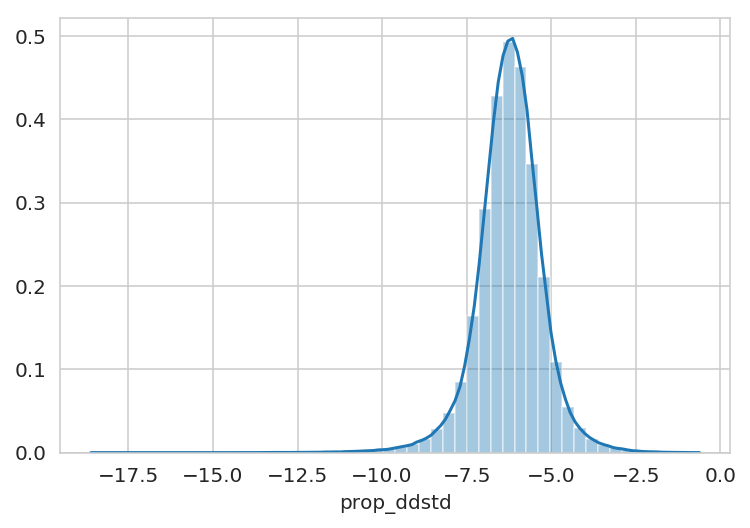

In [39]:
#Check consistency/fluctuations of location proportion dd for each day cycle's time interval
print('median prop_dd:', np.log(df3_train2['prop_ddstd'].median()))
sns.distplot(np.log(df3_train2[df3_train2['prop_ddstd']!=0]['prop_ddstd']))
plt.show()
#fluctuation of prop_dd has a lognormal distribution but a heavier left tail. Most geolocation has low fluctuations in proportion demand, consistency is present / low data available for these geolocations as well.. 

In [40]:
#as we are predicting prop_dd (before getting actual demand from multiplying cluster forecast), 
#remove demand from the data set and use prop_dd as target variable.
#merge geolocation historic features from training set to test set (features are acquired prior to test time)
df3_train_feat = df3_train.drop(['demand'],axis=1).merge(df3_train2, left_on = ['geohash6','cluster','daycycle','hour','minute'], 
                                                         right_on = ['geohash6','cluster','daycycle','hour','minute'],
                                                         how = 'inner',suffixes=['','_feat'])
df3_test_feat = df3_test.drop(['demand'],axis=1).merge(df3_train2, left_on = ['geohash6','cluster','daycycle','hour','minute'], 
                                                       right_on = ['geohash6','cluster','daycycle','hour','minute'],
                                                       how = 'inner',suffixes=['','_feat'])

In [41]:
df3_train_feat.head()

geohash6  latitude  longitude     ...      prop_ddmean prop_ddmin  prop_ddmax
0   qp03wc  0.533333   0.171429     ...         0.004817   0.002303     0.00688
1   qp03wc  0.533333   0.171429     ...         0.004817   0.002303     0.00688
2   qp03wc  0.533333   0.171429     ...         0.004817   0.002303     0.00688
3   qp03wc  0.533333   0.171429     ...         0.004817   0.002303     0.00688
4   qp03wc  0.533333   0.171429     ...         0.004817   0.002303     0.00688

[5 rows x 19 columns]

In [42]:
#train-test split
#dummy obj variables
#dont use geohash6 as dummy, giving too sparse matrix. use lat and longitude instead, under continuous variables
X_train = pd.get_dummies(df3_train_feat,columns=['cluster','daycycle','hour','minute'],
                         drop_first=True).drop(['prop_dd','geohash6'],axis=1).values
y_train = df3_train_feat['prop_dd'].values

X_test = pd.get_dummies(df3_test_feat,columns=['cluster','daycycle','hour','minute'],
                        drop_first=True).drop(['prop_dd','geohash6'],axis=1).values
y_test = df3_test_feat['prop_dd'].values

# Use basic linear regression. Have tried various other models - ridge, lasso, neural nets. Performance slightly better but with much longer processing time. Not worth it.**

In [43]:
lm = linear_model.LinearRegression()
#fit model
model_lm = lm.fit(X_train, y_train)
predictions = model_lm.predict(X_test)

In [44]:
print('In-sample R-sq:',model_lm.score(X_train, y_train))
print('Out-sample R-sq:',model_lm.score(X_test, y_test))
print('MSE:', mean_squared_error(y_test, predictions))

In-sample R-sq: 0.7634835753770657
Out-sample R-sq: 0.6383460038987895
MSE: 4.508654604581943e-05


The X predictors could explain about 64% of the target (proportion of demand) variation.

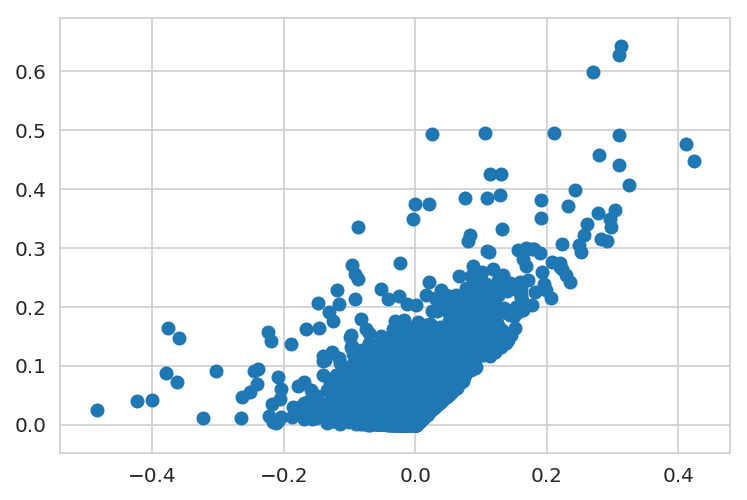

In [45]:
resid = y_test - predictions
plt.scatter(resid, y_test)
#there are still unobserved linear relationship present, must further tease out in next iteration

# Check two layer model performance. 
1. First get the predicted cluster time series demand.
2. Second get the distributed predicted demand for each geolocation at the specific time.
3. Compare these predictions against the actual demand.

In [46]:
#get dummy daterange for the forecasted clusters' demand
date_first = pd.Timestamp(2019,2,25,22,0)
date_last = df['dum_time'].max() 
test_dum_time = pd.date_range(date_first, date_last, freq='15min')

In [47]:
ts_ypred1 = pd.DataFrame(y_pred[1])
ts_ypred1['dum_time'] = test_dum_time
ts_ypred1.columns=['clust0','clust1','clust2','clust3','clust4','clust5','dum_time']
ts_ypred1 = pd.melt(ts_ypred1, id_vars=['dum_time'], value_vars=['clust0','clust1','clust2','clust3','clust4','clust5'])
ts_ypred1.columns=['dum_time','cluster','demand_sect']
ts_ypred1.head()

dum_time cluster  demand_sect
0 2019-02-25 22:00:00  clust0     2.805742
1 2019-02-25 22:15:00  clust0     3.070033
2 2019-02-25 22:30:00  clust0     3.609642
3 2019-02-25 22:45:00  clust0     4.370662
4 2019-02-25 23:00:00  clust0     7.011278

In [48]:
test_df = df3[df3['dum_time'] >= pd.Timestamp(2019,2,25,22,0)]
test_df.head()
test_df = test_df.merge(ts_ypred1, left_on = ['dum_time','cluster'], right_on = ['dum_time','cluster'],how = 'inner',suffixes=['','_pred'] )

In [49]:
test_df.head()

dum_time geohash6        ...          prop_dd  demand_sect_pred
0 2019-02-26 10:00:00   qp091w        ...         0.000382         22.755293
1 2019-02-26 10:00:00   qp03w2        ...         0.001464         22.755293
2 2019-02-26 10:00:00   qp03q5        ...         0.003676         22.755293
3 2019-02-26 10:00:00   qp03ws        ...         0.008920         22.755293
4 2019-02-26 10:00:00   qp02zn        ...         0.008301         22.755293

[5 rows x 12 columns]

In [50]:
#merge geolocation historic features from training set (features acquired prior to test time)
test_df_feat = test_df.merge(df3_train2, left_on = ['geohash6','cluster','daycycle','hour','minute'], 
                             right_on = ['geohash6','cluster','daycycle','hour','minute'],
                             how = 'inner',suffixes=['','_feat'])
test_df_feat.head()

dum_time geohash6     ...      prop_ddmin  prop_ddmax
0 2019-02-26 10:00:00   qp091w     ...        0.000858    0.005356
1 2019-02-26 10:00:00   qp03w2     ...        0.001514    0.004423
2 2019-02-26 10:00:00   qp03q5     ...        0.003653    0.007629
3 2019-02-26 10:00:00   qp03ws     ...        0.005492    0.011858
4 2019-02-26 10:00:00   qp02zn     ...        0.004059    0.012453

[5 rows x 22 columns]

In [51]:
#get dummies into test set, remove irrelevant columns
test_df_feat2 = pd.get_dummies(test_df_feat,columns=['cluster','daycycle','hour','minute'],
                           drop_first=True).drop(['prop_dd','geohash6'],axis=1)

# use demand_sect_pred instead of demand_sect
X_test_cols = ['latitude', 'longitude', 'demand_sect_pred', 'demandmedian', 'demandstd',
       'demandmean', 'demandmin', 'demandmax', 'prop_ddmedian', 'prop_ddstd',
       'prop_ddmean', 'prop_ddmin', 'prop_ddmax', 'cluster_clust1',
       'cluster_clust2', 'cluster_clust3', 'cluster_clust4', 'cluster_clust5',
       'daycycle_2', 'daycycle_3', 'daycycle_4', 'daycycle_5', 'daycycle_6',
       'daycycle_7', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'minute_15',
       'minute_30', 'minute_45']
X_test_ts1 = test_df_feat2[X_test_cols].values
y_test_ts1 = test_df_feat2['demand'].values

In [52]:
pred_propdd_ts1 = model_lm.predict(X_test_ts1)

In [53]:
test_df_feat['pred_propdd_ts1'] = pd.DataFrame(pred_propdd_ts1)
test_df_feat['pred_demand_ts1'] = test_df_feat['demand_sect_pred'] * test_df_feat['pred_propdd_ts1']
#cap prediction with demand>1 to 1
test_df_feat['pred_demand_ts1'] = test_df_feat['pred_demand_ts1'].apply(lambda x: 1 if x>1 else x)
test_df_feat['resid_ts1'] = test_df_feat['demand'] - test_df_feat['pred_demand_ts1']

In [54]:
mean_val = test_df_feat['demand'].mean()
rmse = mean_squared_error(test_df_feat['pred_demand_ts1'], test_df_feat['demand'])
error_perc_ts1 = rmse/mean_val*100
print('Demand mean value:', mean_val)
print('RMSE:', rmse)
print('%_error:', error_perc_ts1)

Demand mean value: 0.11490767849783833
RMSE: 0.002238881348409419
%_error: 1.9484175275993738


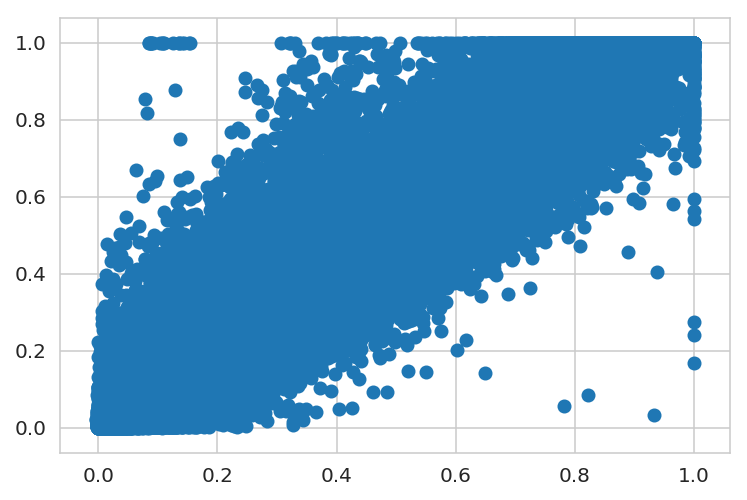

In [55]:
plt.scatter(x=test_df_feat['pred_demand_ts1'], y=test_df_feat['demand'])
#prediction largely aligns with actual demand

The graph shows a plot of time step 1 ahead forecasted demand (x-axis) vs actual demand (y-axis). <br>

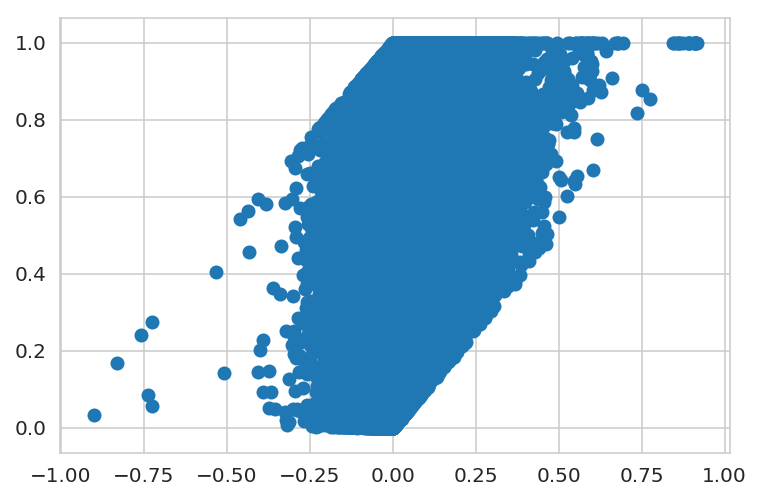

In [56]:
plt.scatter(x=test_df_feat['resid_ts1'], y=test_df_feat['demand'])
#prediction largely aligns with actual demand

Residuals (x-aixs) vs actual demand (y-axis) plot. Residuals are not normally distributed. There is remaining linear relationship present to be teased out. For further iterations.

The End